<a href="https://colab.research.google.com/github/Raychanan/Homework-Notebooks/blob/main/7_Vector_Space_Word_Embeddings_HW_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [ ]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [ ]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [ ]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, feature, fergus, fall, bakery], [..."
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...,"[[Sen, Klobuchar, Showcases, Local, Efforts, t...","[[sen, klobuchar, showcase, local, effort, com..."
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...,"[[Klobuchar, Urges, Fellow, Senators, to, Supp...","[[klobuchar, urge, fellow, senator, support, w..."
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...,"[[Senator, Klobuchar, Wins, Passage, of, Cellu...","[[senator, klobuchar, win, passage, cellulosic..."
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...,"[[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...","[[klobuchar, give, yellow, ribbon], [place, ar..."
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...,"[[Sen, Klobuchar, Statement, in, Observance, o...","[[sen, klobuchar, statement, observance, memor..."
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...,"[[Klobuchar, Secures, 2, 5, Million, for, Vete...","[[klobuchar, secure, veteran, education, healt..."
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, pass, committee]..."
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...,"[[Sen, Klobuchar, Urges, Minnesotans, Travelin...","[[sen, klobuchar, urge, minnesotans, travel, c..."
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...,"[[Klobuchar, Co, sponsors, Emergency, LIHEAP, ...","[[klobuchar, co, sponsor, emergency, liheap, f..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [ ]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([-0.48033676, -0.49907076, -0.12563428,  0.36635143,  0.99469095,
       -1.1216103 ,  0.7808449 ,  0.06897827, -0.57774   , -2.07946   ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

array([[-1.29856586e+00,  3.12571883e-01, -6.46152675e-01, ...,
         9.90776777e-01,  3.24493676e-01, -3.64532650e-01],
       [-5.22194020e-02,  8.59209478e-01,  3.19032729e-01, ...,
         3.52013648e-01, -1.16896284e+00,  2.74213433e-01],
       [-1.01878238e+00, -1.12904084e+00,  1.41845834e+00, ...,
         1.35756409e+00, -1.91561925e+00, -5.78513026e-01],
       ...,
       [ 4.52833958e-02,  2.88827904e-02,  1.05804885e-02, ...,
         3.02729080e-03, -1.60823800e-02,  1.90404593e-03],
       [ 7.31514394e-02,  7.75759444e-02, -3.27942707e-02, ...,
         1.56790502e-02, -5.40540777e-02,  1.08741418e-01],
       [ 1.27396733e-02,  3.58242914e-02, -1.09655457e-02, ...,
         4.18828800e-02, -6.01133378e-03,  1.43555487e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.most_similar('president')

[('administration', 0.8283464312553406),
 ('presidents', 0.7914415597915649),
 ('administrations', 0.7751102447509766),
 ('linean', 0.6842581629753113),
 ('cheney', 0.6636990308761597),
 ('rollback', 0.6445888876914978),
 ('responds', 0.6028443574905396),
 ('veto', 0.596078634262085),
 ('reserving', 0.5842287540435791),
 ('w.', 0.5778374671936035)]

In [ ]:
senReleasesW2V.most_similar('war')

[('invade', 0.6993921995162964),
 ('wars', 0.6972939968109131),
 ('unresisted', 0.693369448184967),
 ('afghanistan', 0.6870641112327576),
 ('liberation', 0.6825169324874878),
 ('foment', 0.6709116101264954),
 ('disobedience', 0.6639421582221985),
 ('unwinnable', 0.6385154724121094),
 ('eviction', 0.6379228830337524),
 ('chaos', 0.6280709505081177)]

Find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('reagan', 0.7111105918884277),
 ('nixon', 0.6991130113601685),
 ('signature', 0.67856764793396),
 ('roosevelt', 0.6618903875350952),
 ('bushs', 0.6556457281112671),
 ('bush', 0.6553600430488586),
 ('dwight', 0.6487621665000916),
 ('veto', 0.6264448165893555),
 ('ford', 0.6215455532073975),
 ('lyndon', 0.6209505796432495)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.2985659 ,  0.31257188, -0.6461527 , ...,  0.9907768 ,
         0.32449368, -0.36453265],
       [-0.0522194 ,  0.8592095 ,  0.31903273, ...,  0.35201365,
        -1.1689628 ,  0.27421343],
       [-1.0187824 , -1.1290408 ,  1.4184583 , ...,  1.3575641 ,
        -1.9156193 , -0.578513  ],
       ...,
       [ 0.7261309 ,  1.0728214 , -0.25613877, ..., -1.4942498 ,
         1.37964   , -1.0396935 ],
       [-0.45212147,  1.9865396 , -0.5438519 , ...,  0.1781534 ,
         0.72487944, -0.35405028],
       [ 2.120718  ,  1.1636872 , -2.078742  , ...,  1.6376282 ,
         1.7728649 ,  2.885328  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

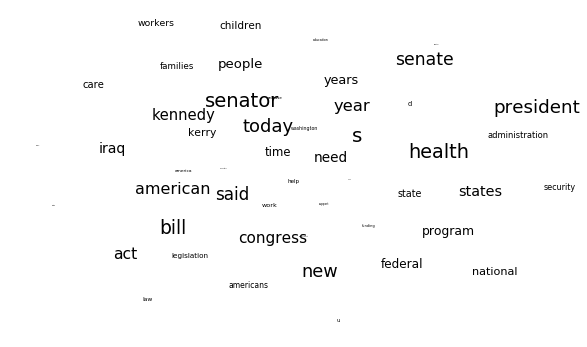

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [ ]:
# I'm running this jupyter notebook in google's colab, so I have to install the package first
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-yntk4f86
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-yntk4f86
     |████████████████████████████████| 5.5MB 6.4MB/s 
     |████████████████████████████████| 122kB 53.2MB/s 
     |████████████████████████████████| 163kB 36.8MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 133kB 55.8MB/s 
     |████████████████████████████████| 32.8MB 120kB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 5.1MB 43.0MB/s 
     |████████████████████████████████| 7.3MB 41.4MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-cp37-none-any.whl size=34914 sha256=286f6128283cc7708540a90965c95e69c5c197c6601c8319a93a04be92928c5d
  Stored in directory: /tmp/pip-ephem-wh

In [ ]:
# Load data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [ ]:
newsDF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AG_News_Classification_Dataset/test.csv")

In [ ]:
newsDF[:3]

# Consists of 1-4 numbers which represents class of which 1-World, 2-Sports, 3-Business, 4-Sci/Tech

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [ ]:
newsDF.columns = ['category', 'title', 'text']
newsDF[:3]

,category,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [ ]:
# When we normalize here, we don't use the lematized form of the word 

# Apply our functions, each row is a list of lists now
newsDF['tokenized_sents'] = newsDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
newsDF['normalized_sents'] = newsDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

newsDF[:100:10]

,category,title,text,tokenized_sents,normalized_sents
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[[Unions, representing, workers, at, Turner, N...","[[union, represent, worker, turner, newall, di..."
10,4,Group to Propose New High-Speed Wireless Format,LOS ANGELES (Reuters) - A group of technology...,"[[LOS, ANGELES, Reuters], [A, group, of, techn...","[[los, angeles, reuters], [group, technology, ..."
20,4,IBM to hire even more new workers,"By the end of the year, the computing giant pl...","[[By, the, end, of, the, year, the, computing,...","[[end, year, compute, giant, plan, big, headco..."
30,2,They've caught his eye,"In quot;helping themselves, quot; Ricky Bryan...","[[In, quot;helping, themselves, quot, Ricky, B...","[[quot;helping, quot, ricky, bryant, chas, ges..."
40,2,Johnson Helps D-Backs End Nine-Game Slide (AP),AP - Randy Johnson took a four-hitter into the...,"[[AP, Randy, Johnson, took, a, four, hitter, i...","[[ap, randy, johnson, take, hitter, 9, inning,..."
50,1,US fighter squadron to be deployed in South Ko...,AFP - A squadron of US Air Force F-15E fighter...,"[[AFP, A, squadron, of, US, Air, Force, F-15E,...","[[afp, squadron, air, force, f-15e, fighter, b..."
60,2,"Sutton Adds Haas, Cink to Ryder Cup Team",MILWAUKEE (Sports Network) - U.S. Ryder Cup c...,"[[MILWAUKEE, Sports, Network], [U.S., Ryder, C...","[[milwaukee, sport, network], [u.s, ryder, cup..."
70,4,China's Red Flag Linux to focus on enterprise,"Red Flag Software Co., the company behind Chin...","[[Red, Flag, Software, Co., the, company, behi...","[[red, flag, software, co., company, china, le..."
80,1,"Kerry Widens Lead in California, Poll Finds (R...",Reuters - Democratic challenger John Kerry\has...,"[[Reuters, Democratic, challenger, John], [Ker...","[[reuters, democratic, challenger, john], [ker..."
90,1,U.S. Brokers Cease-fire in Western Afghanistan,KABUL (Reuters) - The United States has broke...,"[[KABUL, Reuters], [The, United, States, has, ...","[[kabul, reuters], [unite, state, broker, ceas..."


In [ ]:
# Now get started with Word2Vec

# To load data, give all the sentences to the trainer
newsW2V = gensim.models.word2vec.Word2Vec(newsDF['normalized_sents'].sum())


In [ ]:
# Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (__getitem__) method:

newsW2V['sport'][:5] 


array([0.08583851, 0.52845085, 0.6314979 , 0.08223191, 0.7889772 ],
      dtype=float32)

In [ ]:
# syn0 stores all the vectors:

newsW2V.wv.syn0


array([[ 0.12479074,  0.5516103 ,  0.663605  , ..., -0.9374029 ,
        -0.22834319, -0.42645326],
       [ 0.07573353,  0.5297759 ,  0.6323817 , ..., -0.8913562 ,
        -0.17766796, -0.43730336],
       [ 0.2247521 ,  0.8032306 ,  0.69951904, ..., -0.78141755,
        -0.06841239, -0.7569945 ],
       ...,
       [ 0.01110753,  0.06015632,  0.06495586, ..., -0.09495931,
        -0.02400632, -0.04654989],
       [ 0.00822696,  0.06597833,  0.07736003, ..., -0.10874706,
        -0.01823938, -0.05187408],
       [ 0.01403346,  0.07877678,  0.09504087, ..., -0.13018472,
        -0.03281309, -0.06921388]], dtype=float32)

In [ ]:
# index2word translates from the matrix to words:

newsW2V.wv.index2word[5]


'company'

In [ ]:
# Look at a few things that come from the word vectors. 
# The first is to find similar vectors (cosine similarity)

newsW2V.most_similar('china')

# some interesting similar keywords: "begin", "control", "japan"

[('fail', 0.9998289346694946),
 ('step', 0.9998235106468201),
 ('turn', 0.9998225569725037),
 ('worker', 0.9998222589492798),
 ('hurricane', 0.9998188018798828),
 ('reach', 0.9998188018798828),
 ('charge', 0.9998165369033813),
 ('seek', 0.9998153448104858),
 ('come', 0.9998040795326233),
 ('confirm', 0.9998027086257935)]

In [ ]:
newsW2V.most_similar('korea')

# some interesting similar keywords: "worker", "southern", "western"

[('nuclear', 0.999625563621521),
 ('cause', 0.9996175765991211),
 ('death', 0.9996154308319092),
 ('island', 0.9995956420898438),
 ('hour', 0.999578595161438),
 ('war', 0.999576210975647),
 ('worker', 0.9995741844177246),
 ('political', 0.9995734691619873),
 ('party', 0.999569833278656),
 ('southern', 0.9995688796043396)]

In [ ]:
newsW2V.most_similar('japan')

# no interesting similar keywords...

[('like', 0.9998781681060791),
 ('old', 0.9998646378517151),
 ('face', 0.9998616576194763),
 ('long', 0.9998613595962524),
 ('scientist', 0.9998605847358704),
 ('try', 0.9998593330383301),
 ('hope', 0.999857485294342),
 ('claim', 0.9998550415039062),
 ('complete', 0.9998549222946167),
 ('fan', 0.9998496770858765)]

In [ ]:
newsW2V.most_similar('eu')
# some interesting similar keywords:: "change", "rule", "scientist", "law"

[('arm', 0.9997831583023071),
 ('tell', 0.9997766017913818),
 ('seek', 0.9997745752334595),
 ('reject', 0.9997722506523132),
 ('island', 0.9997714161872864),
 ('accuse', 0.9997696876525879),
 ('begin', 0.9997683763504028),
 ('council', 0.9997677206993103),
 ('action', 0.999764084815979),
 ('ban', 0.9997599720954895)]

In [ ]:
newsW2V.most_similar('uk')

# no interesting similar keywords

[('program', 0.9998831748962402),
 ('make', 0.9998822808265686),
 ('radio', 0.9998593330383301),
 ('digital', 0.9998546838760376),
 ('receive', 0.9998528957366943),
 ('provide', 0.9998470544815063),
 ('problem', 0.9998462200164795),
 ('begin', 0.9998427033424377),
 ('small', 0.9998413920402527),
 ('show', 0.9998350739479065)]

In [ ]:
# Find which word least matches the others within a word set (cosine similarity):

In [ ]:
newsW2V.doesnt_match(['china', 'japan', 'korea', 
                      'uk', 'eu', 'tokyo'])

# Make sense. tokyo is the only city in this list

'tokyo'

In [ ]:
# Find which word best matches the result of a semantic equation 
# equation: X + Y - Z = _

In [ ]:
newsW2V.most_similar(positive=['beijing', 'japan'], negative = ['china'])

# we see that beijing + jpan - china = chicago. 
# In other words, in this dataset, beijing is to china as japan is to chicago. 
# well... that's not quite true... 



[('home', 0.9993689060211182),
 ('athens', 0.9993473291397095),
 ('discover', 0.9993336796760559),
 ('paris', 0.9993201494216919),
 ('watch', 0.9993112087249756),
 ('study', 0.9992931485176086),
 ('design', 0.9992777109146118),
 ('fee', 0.9992598295211792),
 ('england', 0.9992589354515076),
 ('important', 0.9992542862892151)]

In [ ]:
newsW2V.most_similar(positive=['beijing', 'eu'], negative = ['china'])

# this makes sense.
# beijing is to china as eu is to paris. 

[('important', 0.9992664456367493),
 ('discover', 0.9992431998252869),
 ('office', 0.9992160797119141),
 ('manager', 0.9991970658302307),
 ('position', 0.9991912245750427),
 ('aim', 0.9991831183433533),
 ('name', 0.9991739392280579),
 ('watch', 0.9991703629493713),
 ('prince', 0.9991597533226013),
 ('rocket', 0.9991500377655029)]

In [ ]:
newsW2V.most_similar(positive=['seoul', 'japan'], negative = ['korea'])

# this time it pops up "tokyo". That's great!

[('london', 0.9981569647789001),
 ('tokyo', 0.9977519512176514),
 ('washington', 0.997514009475708),
 ('seattle', 0.9974682331085205),
 ('unveil', 0.9974395036697388),
 ('chicago', 0.9974042177200317),
 ('warner', 0.9971790909767151),
 ('jerusalem', 0.9970961213111877),
 ('delta', 0.9970100522041321),
 ('jet', 0.9969428181648254)]

In [ ]:
# save the vectors for later use:
newsW2V.save("newsWORD2Vec")


In [ ]:
# We can also use dimension reduction to visulize the vectors. 
# We will start by selecting a subset we want to plot. 
# Let's look at the top words from the set



In [ ]:
numWords = 150
targetWords = newsW2V.wv.index2word[:numWords]

In [ ]:
# extract vectors and create our own smaller matrix 
# that preserved the distances from the original:

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(newsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.20941111,  0.304768  ,  0.5080827 , ..., -0.01269206,
         0.21423295, -0.16997811],
       [-0.1712877 ,  0.32696125,  0.5004173 , ..., -0.04932687,
         0.24167821, -0.15716529],
       [-0.42786533,  0.30725214,  0.41383636, ...,  0.15240593,
        -0.01230832, -0.33666927],
       ...,
       [-0.22015394,  0.27699676,  0.46989202, ...,  0.00092421,
         0.17566383, -0.19551946],
       [-0.2382812 ,  0.30537614,  0.52787197, ..., -0.01010215,
         0.19990139, -0.20786577],
       [-0.22291383,  0.30474123,  0.50714564, ..., -0.01809497,
         0.20150878, -0.19441941]], dtype=float32)

In [ ]:
# use PCA to reduce the dimesions (e.g., to 60), and T-SNE to project them down to the two we will visualize. 
# this is nondeterministic process, and results cannot accurately reappear 

pcaWords = sklearn.decomposition.PCA(n_components = 60).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

#T-SNE is theoretically better
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

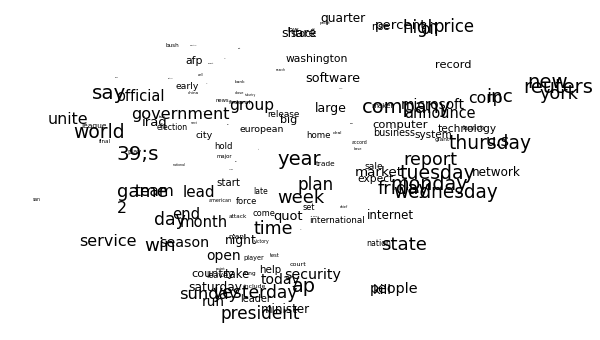

In [ ]:
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
# The densest place in this plot is about days and dates
# monday, wed, tuesday, friday, week, month...
# "president" is close to words including "security", "minister", "leader", "court"

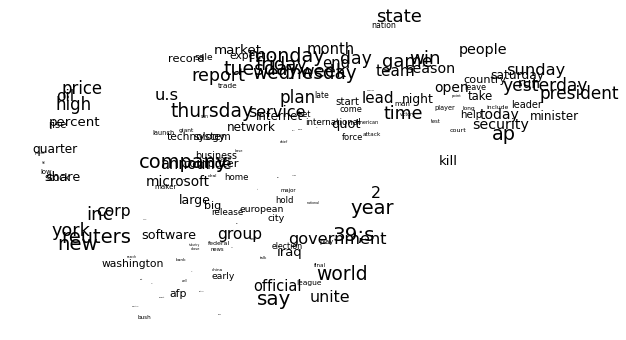

In [ ]:
# change n_components of PCA to 100
pcaWords = sklearn.decomposition.PCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# the result mains the same in general:
# The densest place in this plot is about days and dates
# monday, wed, tuesday, friday, week, month...
# "president" is close to words including "security", "minister", "leader", "court"

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


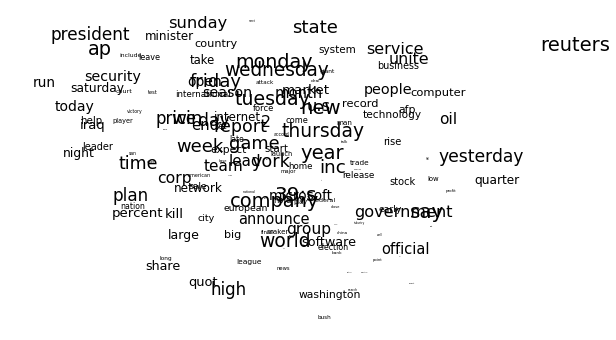

In [ ]:
# change n_components of PCA to 100 and the number of n_components of t-sne to 4
pcaWords = sklearn.decomposition.PCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 3).fit_transform(reducedPCA_data)

# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], 
            tsneWords[:, 2], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# again, the result mains the same in general:
# The densest place in this plot is about days and dates
# monday, wed, tuesday, friday, week, month...
# "president" is close to words including "security", "minister", "leader", "court"

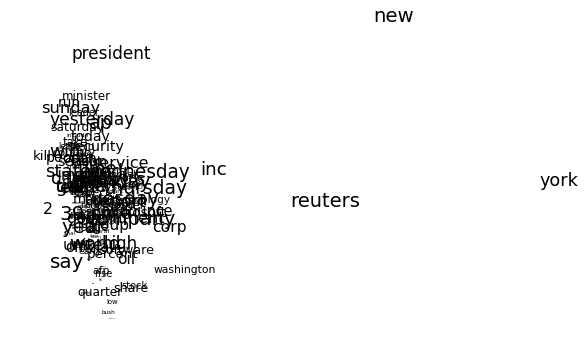

In [ ]:
# Use PCA method?
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# First of all, the plot becomes much denser
# The densest place in this plot is still about dates

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


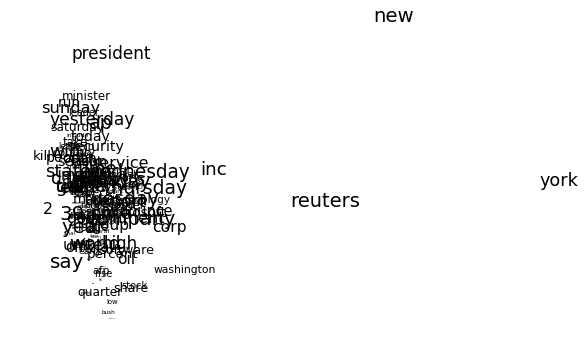

In [ ]:
# Use PCA method and change n_components to 4?
pcaWords = sklearn.decomposition.PCA(n_components = 4).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], 
            reducedPCA_data[:, 2], reducedPCA_data[:, 3],
            alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# seems like there is not a big change

In [ ]:
# so in this case, I think the t-sne method gives me results that are more meaningful
# t-sne method gives me more insights while the PCA method is too dense to offer
# much useful information 
# however, in terms of the robustness, I think the PCA method performs better in this aspect


In [ ]:
# Now, please let me change my dataset and reapply the techniques that I have just learned

In [ ]:
articlesDF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Sentiment.csv")

In [ ]:
articlesDF[:3]

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN


In [ ]:
# keep only useful columns

articlesDF = articlesDF[["sentiment", 'text','candidate']]
articlesDF[:3]

,sentiment,text,candidate
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,No candidate mentioned
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,Scott Walker
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,No candidate mentioned


In [ ]:
# rename columns

articlesDF.columns = ['category', 'text', 'candidate']
articlesDF[:3]

,category,text,candidate
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,No candidate mentioned
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,Scott Walker
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,No candidate mentioned


In [ ]:
# When we normalize here, we don't use the lematized form of the word 

# Apply our functions, each row is a list of lists now
articlesDF['tokenized_sents'] = articlesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
articlesDF['normalized_sents'] = articlesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

articlesDF[:100:10]

,category,text,candidate,tokenized_sents,normalized_sents
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,No candidate mentioned,"[[RT, @NancyLeeGrahn], [How, did, everyone, fe...","[[rt, @nancyleegrahn], [feel, climate, change,..."
10,Negative,@JGreenDC @realDonaldTrump In all fairness #Bi...,Donald Trump,"[[@JGreenDC, @realDonaldTrump], [In, all, fair...","[[@jgreendc, @realdonaldtrump], [fairness, bil..."
20,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, t...",Ted Cruz,"[[RT], [@ChuckNellis], [Cruz, has, class, amp,...","[[rt], [@chucknellis], [cruz, class, amp, trut..."
30,Negative,@fbhw they're going to need to borrow the trai...,No candidate mentioned,"[[@fbhw, they, 're, going, to, need, to, borro...","[[@fbhw, go, need, borrow, train, horn, gopdeb..."
40,Negative,RT @mgell: Trump is a cross between the shrug ...,Donald Trump,"[[RT, @mgell], [Trump, is, a, cross, between, ...","[[rt, @mgell], [trump, cross, shrug, emoji, pr..."
50,Neutral,RT @ariannahuff: The best and worst from the #...,No candidate mentioned,"[[RT, @ariannahuff, The, best, and, worst, fro...","[[rt, @ariannahuff, well, wrong, gopdebate, ht..."
60,Negative,RT @P0TUS: #GOPDebate closing statements: http...,No candidate mentioned,"[[RT, @P0TUS, GOPDebate, closing, statements, ...","[[rt, @p0tus, gopdebate, close, statement, htt..."
70,Negative,Fox News Had Its Own #GOPDebate Agenda: Promot...,Donald Trump,"[[Fox, News, Had, Its, Own, GOPDebate, Agenda]...","[[fox, news, gopdebate, agendum], [promote, ca..."
80,Negative,"RT @lolhayley: ""The purpose of the military is...",No candidate mentioned,"[[RT, @lolhayley, The, purpose, of, the, milit...","[[rt, @lolhayley, purpose, military, kill, peo..."
90,Positive,Even though she's a super conservative reporte...,No candidate mentioned,"[[Even, though, she, 's, a, super, conservativ...","[[super, conservative, reporter, actually, lik..."


In [ ]:
# Now get started with Word2Vec

# To load data, give all the sentences to the trainer
articlesW2V = gensim.models.word2vec.Word2Vec(articlesDF['normalized_sents'].sum())



In [ ]:
# access the vector directly
articlesW2V['trump'][:5]

array([ 0.43694553,  0.33601338,  0.08931883, -0.49491924, -0.7075342 ],
      dtype=float32)

In [ ]:
# full matrix
articlesW2V.wv.syn0

array([[-1.5115787e-02, -1.8409182e-01,  4.8353501e-02, ...,
         7.5492674e-01, -3.6611629e-01, -4.0085417e-01],
       [ 6.7303039e-02,  6.4861007e-02,  1.6470209e-02, ...,
         3.8437170e-01, -3.6186710e-01, -4.0384975e-01],
       [ 7.3821694e-02, -2.5910118e-01, -3.1210555e-02, ...,
         7.6757985e-01, -4.1507998e-01, -4.8407632e-01],
       ...,
       [ 5.7232222e-03,  6.7926836e-03, -1.9972003e-03, ...,
         1.3975212e-02, -2.1761198e-02, -3.1673159e-02],
       [ 1.9115428e-03,  4.9555958e-03,  1.0303020e-02, ...,
         6.3712969e-02, -5.4560073e-02, -6.2181022e-02],
       [-6.7528791e-04,  2.2469060e-03,  2.3933013e-03, ...,
        -1.9791503e-04,  6.1250996e-04, -3.0839618e-03]], dtype=float32)

In [ ]:
# translate from the matrix to words:
articlesW2V.wv.index2word[20]


'say'

In [ ]:
articlesW2V.most_similar('trump')


[('donald', 0.9796384572982788),
 ('@ericstonestreet', 0.9671605825424194),
 ('cam', 0.9619878530502319),
 ('say', 0.949096143245697),
 ('legitimate', 0.9386494755744934),
 ('hand', 0.935420036315918),
 ('think', 0.9280585050582886),
 ('biff', 0.9200642704963684),
 ('@kesgardner', 0.9153047800064087),
 ('@teapainusa', 0.9143608212471008)]

In [ ]:
articlesW2V.most_similar('health')

# interesting keywords:

[('likely', 0.9985424280166626),
 ('pig', 0.9984481334686279),
 ('consider', 0.9983478784561157),
 ('surprise', 0.9983053803443909),
 ('murder', 0.998219907283783),
 ('disgust', 0.9982115030288696),
 ('white', 0.9981606006622314),
 ('politically', 0.9981429576873779),
 ('little', 0.9981334805488586),
 ('idiot', 0.9979159832000732)]

In [ ]:
articlesW2V.most_similar('china')

# interesting keywords: russia, socialist

[('russia', 0.9984510540962219),
 ('pay', 0.9980936646461487),
 ('personality', 0.9977397918701172),
 ('socialist', 0.9976912140846252),
 ('sell', 0.9973495006561279),
 ('@gop', 0.9972933530807495),
 ('beg', 0.9972438812255859),
 ('respect', 0.9972397089004517),
 ('baby', 0.9972369074821472),
 ('establishment', 0.9972123503684998)]

In [ ]:
articlesW2V.most_similar('security')

# interesting keywords: school

[('kinda', 0.99831622838974),
 ('snl', 0.998292088508606),
 ('school', 0.9981400966644287),
 ('dad', 0.9981192350387573),
 ('limit', 0.9981186389923096),
 ('putt', 0.9980801939964294),
 ('marriage', 0.9980779886245728),
 ('wed', 0.9980486631393433),
 ('nonsense', 0.9980443716049194),
 ('credit', 0.9980368614196777)]

In [ ]:
articlesW2V.most_similar('black')

# interesting keywords: hate, care, correct

[('whererwomen', 0.9973933696746826),
 ('care', 0.9972805976867676),
 ('allow', 0.9971133470535278),
 ('unborn', 0.9970152974128723),
 ('hate', 0.9969804286956787),
 ('idiot', 0.9969673752784729),
 ('+', 0.9968605041503906),
 ('correct', 0.9968346953392029),
 ('@kwrcrow', 0.9967969059944153),
 ('dc', 0.9967931509017944)]

In [ ]:
# Find which word least matches the others within a word set (cosine similarity):

articlesW2V.doesnt_match(['trump', 'administration', 'government', 'black'])

# I would expect the result to be "black"
# however, it's trump

'trump'

In [ ]:
# Find which word best matches the result of a semantic equation 
articlesW2V.most_similar(positive=['trump', 'democrat'], negative = ['republican'])

# the result is pretty hard to understand

[('@ericstonestreet', 0.9266673922538757),
 ('look', 0.9091860055923462),
 ('cam', 0.9045268297195435),
 ('nail', 0.8983289003372192),
 ('legitimate', 0.8928120136260986),
 ('donald', 0.8813348412513733),
 ('say', 0.8773817420005798),
 ('@larryelder', 0.8732560873031616),
 ('rand', 0.8686001896858215),
 ('hand', 0.8680773973464966)]

In [ ]:
articlesW2V.most_similar(positive=['control', 'america'], negative = ['china'])

# china is to control as america is to watch.

[('watch', 0.9619793891906738),
 ('basis', 0.9456620216369629),
 ('react', 0.9398276805877686),
 ('theatre', 0.9380437135696411),
 ('msn', 0.935016393661499),
 ('@realdonaldtrump', 0.9339881539344788),
 ('iowa', 0.9336618781089783),
 ('hannity', 0.9330623745918274),
 ('debate', 0.9329689145088196),
 ('mean', 0.9309524893760681)]

In [ ]:
#  save the vectors for later use:

articlesW2V.save("articlesWORD2Vec")


In [ ]:
numWords = 150
targetWords = articlesW2V.wv.index2word[:numWords]

In [ ]:
# extract vectors and create our own smaller matrix 
# that preserved the distances from the original:

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(articlesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.01511579, -0.18409182,  0.0483535 , ...,  0.75492674,
        -0.3661163 , -0.40085417],
       [ 0.06730304,  0.06486101,  0.01647021, ...,  0.3843717 ,
        -0.3618671 , -0.40384975],
       [ 0.07382169, -0.25910118, -0.03121055, ...,  0.76757985,
        -0.41507998, -0.48407632],
       ...,
       [-0.48645166,  0.01831686,  0.4412267 , ...,  0.8328807 ,
        -0.06433748, -0.06646098],
       [-0.02883866,  0.03687992,  0.05251629, ...,  0.4469356 ,
        -0.41054252, -0.45103258],
       [-0.02555857, -0.08215575, -0.08352914, ...,  0.30136076,
        -0.79846126, -0.76713514]], dtype=float32)

In [ ]:
# use PCA to reduce the dimesions (e.g., to 60), and T-SNE to project them down to the two we will visualize. 
# this is nondeterministic process, and results cannot accurately reappear 

pcaWords = sklearn.decomposition.PCA(n_components = 60).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

#T-SNE is theoretically better
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


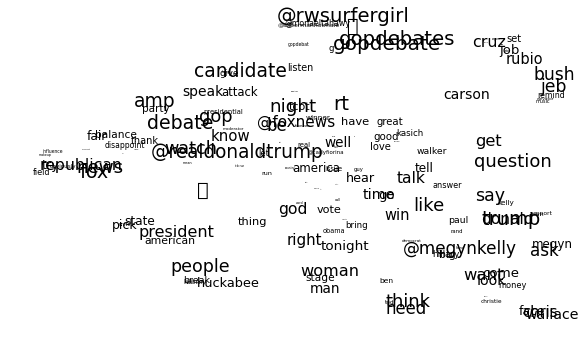

In [ ]:
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
# donald trump's twitter @realdonaldtrump is close to some words like 
# "debate" and his friend "@foxnews", "attack", "disappoint", "fair"

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


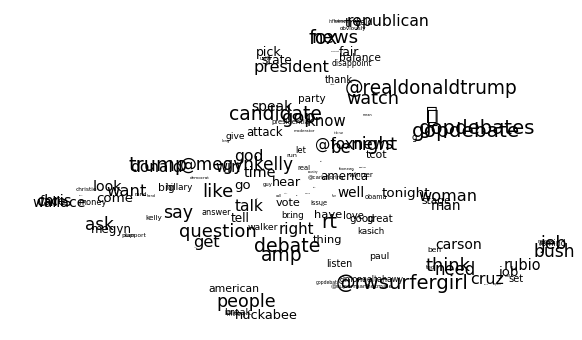

In [ ]:
# change n_components of PCA to 100
pcaWords = sklearn.decomposition.PCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# the result mains the same in general:
# @realdonaldtrump is close to words including 
# fox news, disappoint, watch, thank, fair

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


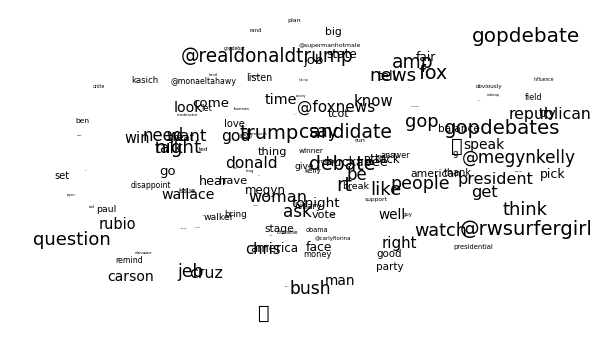

In [ ]:
# change n_components of PCA to 100 and the number of n_components of t-sne to 4
pcaWords = sklearn.decomposition.PCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 3).fit_transform(reducedPCA_data)

# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], 
            tsneWords[:, 2], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# again, the result mains the same in general:
# @realdonaldtrump is close to fox news, fair 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


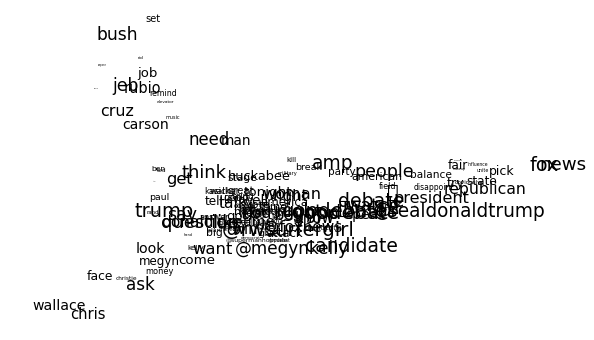

In [ ]:
# Use PCA method?
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# the plot becomes much denser
# The densest place in this plot is still about trump and his related keywords as mentioned above

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


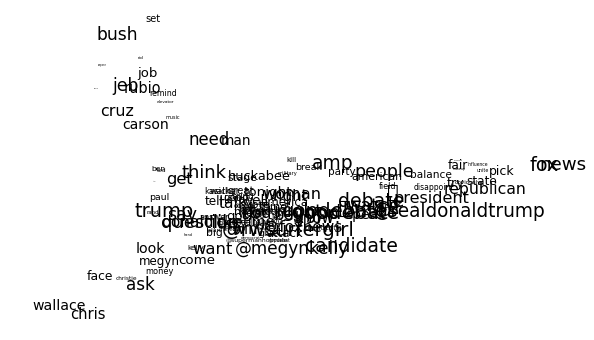

In [ ]:
# Use PCA method and change n_components to 4?
pcaWords = sklearn.decomposition.PCA(n_components = 4).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
# plot the points

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], 
            reducedPCA_data[:, 2], reducedPCA_data[:, 3],
            alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# seems like there is not a big change

In [ ]:
# so in this case, I think the t-sne method "still" gives me results that are more meaningful
# t-sne method "still" gives me more insights while the PCA method is too dense to offer
# much useful information 

# however, in terms of the robustness, I think the PCA method "still" performs better in this aspect

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

array([ 0.19856402, -0.32607275, -0.5434297 ,  1.1079134 , -0.7955435 ,
        0.99836284,  0.02586303, -0.77402437,  0.74257386,  1.140868  ,
       -2.4344554 , -0.13921498, -1.2160647 , -1.4391065 , -0.63838714,
        2.1025863 , -0.12144856, -1.331758  ,  0.01048518, -0.6495456 ,
        1.7060442 ,  0.18673746, -0.35625997, -0.8610773 , -0.86390185,
        1.0696704 , -0.23027356,  0.04415682,  0.92669034, -0.50605357,
       -1.2538182 , -0.8345244 ,  1.09148   , -0.9151546 , -1.3085489 ,
       -1.5950308 , -0.54413456,  2.0067692 ,  0.04618606,  1.4554724 ,
        1.4843128 ,  1.5505302 , -1.2077212 , -0.2808706 ,  1.2828134 ,
        0.9156761 , -0.69469404, -0.44501895, -0.50577635,  0.54679835,
       -0.43360424, -0.2895272 , -1.8368219 ,  0.46414116,  0.60980177,
       -0.03472868,  0.7123255 , -0.79734975,  1.5043598 ,  0.6873778 ,
        1.3033248 , -0.2133346 ,  0.22569688, -1.3537297 ,  0.7381637 ,
       -0.10078208, -1.7898892 , -0.2197677 , -0.65157926, -0.50

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

array([ 0.18284628, -0.04895942, -0.89525455,  0.386619  ,  0.15722378,
        0.28620473,  0.34100235,  0.6834194 , -0.00408947,  0.6566478 ,
       -0.5354382 ,  0.01004452,  0.43740138, -1.091602  ,  0.22807835,
        0.71692365, -0.37653923, -0.10362295, -0.16604191,  0.3131635 ,
       -0.35241136, -0.8172237 ,  0.3936495 , -0.5299927 ,  0.13411738,
        0.2986211 , -0.45632944,  0.00526831,  0.7483204 , -0.34703842,
       -0.8986433 , -0.25062317,  0.16325492, -1.1789956 ,  0.1183672 ,
        0.30810228, -1.107009  ,  0.42208552,  0.41748974,  0.7264739 ,
        0.8722728 ,  1.4183432 , -0.25191745,  0.8265018 ,  0.19808555,
        0.23069115, -0.17685364, -0.29582533,  0.05870611,  0.10616075,
       -0.45562714,  0.17342158, -0.25422886,  0.7015164 ,  0.7497404 ,
       -0.07426755,  1.2640078 , -0.19158858, -0.70047724,  0.10496335,
       -0.91657907, -0.8523482 ,  0.6237608 , -0.09004818,  0.08607046,
       -0.2238795 ,  0.4310083 , -0.21755084, -1.1692094 , -0.53

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('resemblance', 0.9027340412139893)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

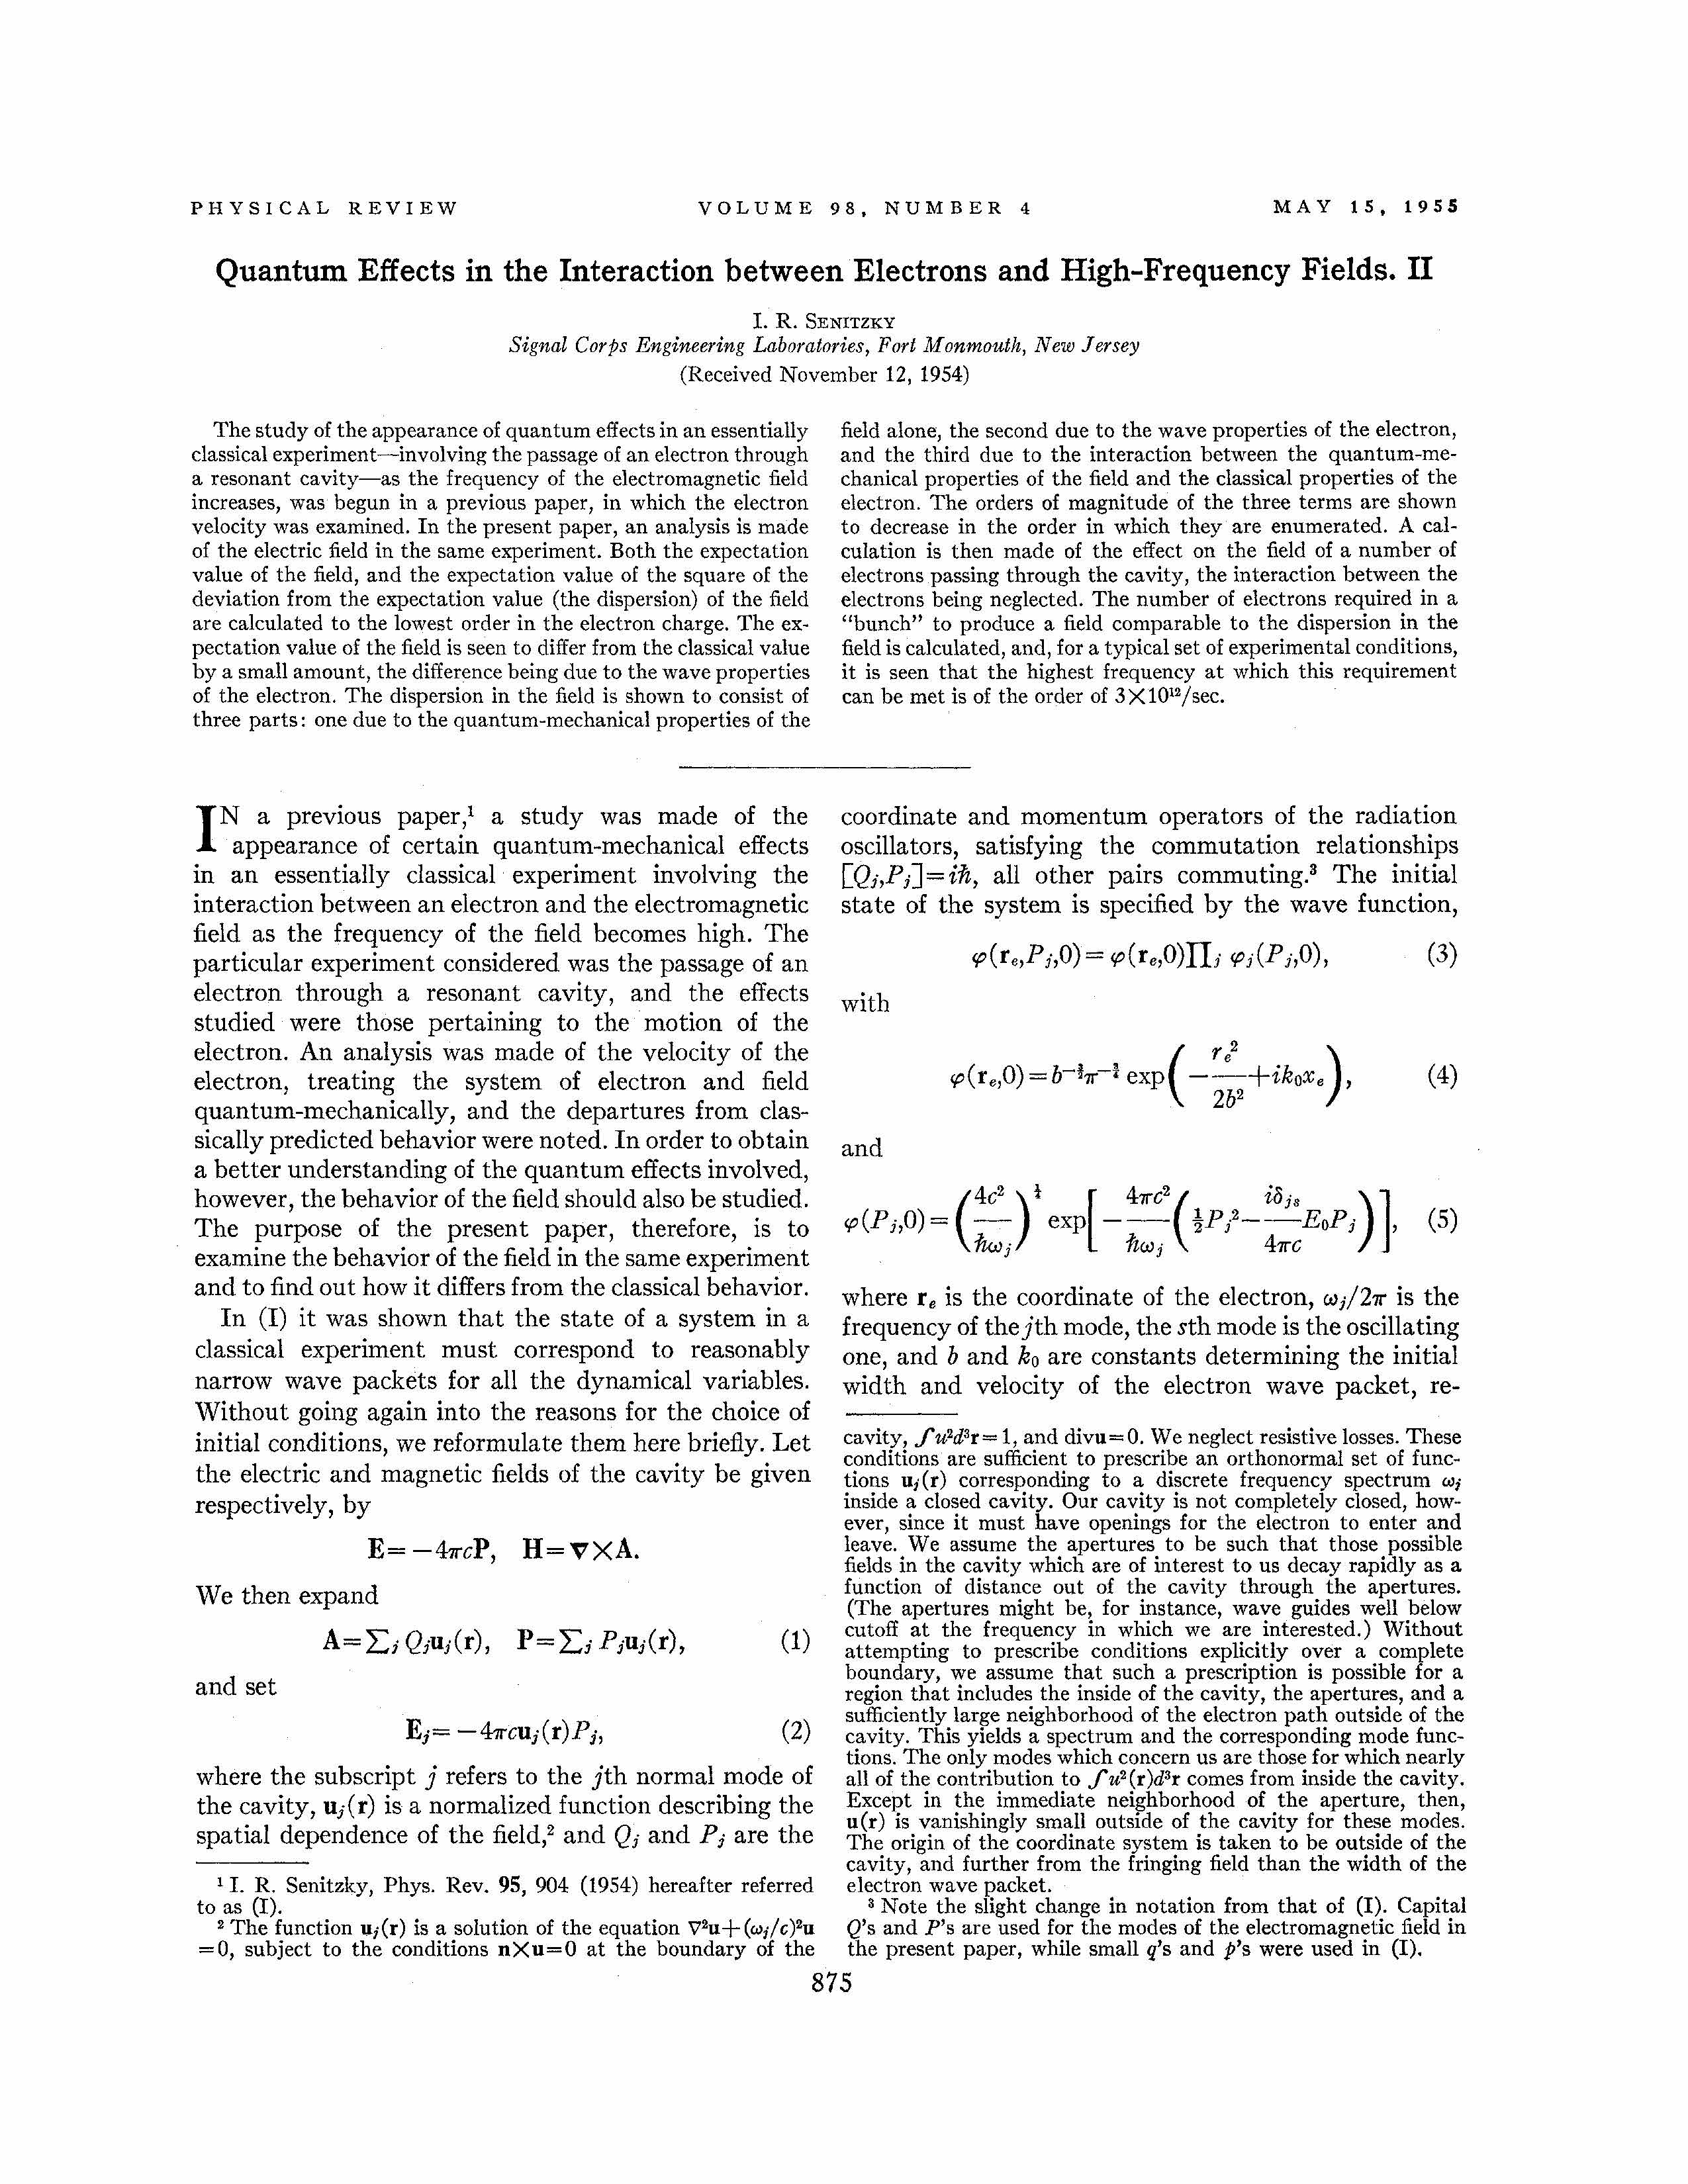

In [ ]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

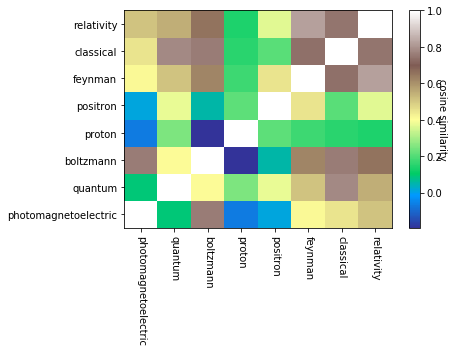

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

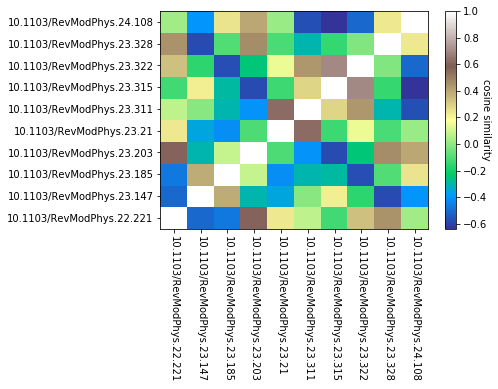

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

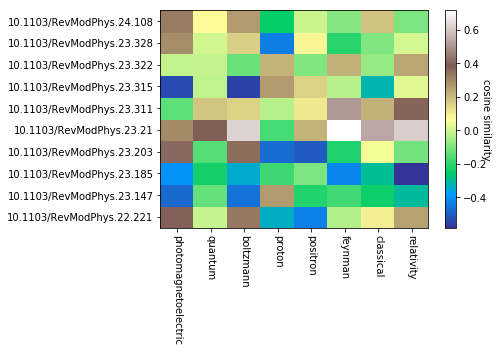

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [ ]:
# I'm running this jupyter notebook in google's colab, so I have to install the package first
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-vogtbzmc
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-vogtbzmc
     |████████████████████████████████| 5.5MB 5.1MB/s 
     |████████████████████████████████| 122kB 40.3MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 133kB 33.1MB/s 
     |████████████████████████████████| 32.8MB 121kB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 5.1MB 43.6MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 7.3MB 36.2MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-cp37-none-any.whl size=34914 sha256=efd89bba6b14111284a0d141ac3f06d3905725f8f207ab73fccbb2d06b92dfec
  Stored in directory: /tmp/pip-ephem-wh

In [ ]:
# Load data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [ ]:
newsDF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AG_News_Classification_Dataset/test.csv")

In [ ]:
newsDF[:3]

# Consists of 1-4 numbers which represents class of which 1-World, 2-Sports, 3-Business, 4-Sci/Tech

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [ ]:
newsDF.columns = ['category', 'id', 'abstract']
newsDF[:3]

,category,id,abstract
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [ ]:
# data loaded

In [ ]:
# load these as documents into Word2Vec, but first we need to normalize and pick some tags.

keywords = ['china', 'japan', 'eu', 'uk', 'international', 'global']

newsDF['tokenized_words'] = newsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
newsDF['normalized_words'] = newsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [ ]:
newsDF.head()

,category,id,abstract,tokenized_words,normalized_words
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[Unions, representing, workers, at, Turner, Ne...","[unions, representing, workers, turner, newall..."
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...","[SPACE.com, TORONTO, Canada, A, second\team, o...","[space.com, toronto, canada, second\team, rock..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,"[AP, A, company, founded, by, a, chemistry, re...","[ap, company, founded, chemistry, researcher, ..."
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,"[AP, It, 's, barely, dawn, when, Mike, Fitzpat...","[ap, barely, dawn, mike, fitzpatrick, starts, ..."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,"[AP, Southern, California, 's, smog, fighting,...","[ap, southern, california, smog, fighting, age..."


In [ ]:
taggedDocs = []
for index, row in newsDF.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['category'])
    docKeywords.append(row['id']) # helps to extract individual documnets
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
newsDF['TaggedAbstracts'] = taggedDocs

In [ ]:
newsDF.head()

,category,id,abstract,tokenized_words,normalized_words,TaggedAbstracts
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[Unions, representing, workers, at, Turner, Ne...","[unions, representing, workers, turner, newall...","([unions, representing, workers, turner, newal..."
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...","[SPACE.com, TORONTO, Canada, A, second\team, o...","[space.com, toronto, canada, second\team, rock...","([space.com, toronto, canada, second\team, roc..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,"[AP, A, company, founded, by, a, chemistry, re...","[ap, company, founded, chemistry, researcher, ...","([ap, company, founded, chemistry, researcher,..."
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,"[AP, It, 's, barely, dawn, when, Mike, Fitzpat...","[ap, barely, dawn, mike, fitzpatrick, starts, ...","([ap, barely, dawn, mike, fitzpatrick, starts,..."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,"[AP, Southern, California, 's, smog, fighting,...","[ap, southern, california, smog, fighting, age...","([ap, southern, california, smog, fighting, ag..."


In [ ]:
# train a Doc2Vec model

In [ ]:
newsD2V = gensim.models.doc2vec.Doc2Vec(newsDF['TaggedAbstracts'], size = 80) # Limite to 80 dimensions


/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
newsD2V

In [ ]:
# can get vectors for the tags/documents, just as we did with words

newsD2V.docvecs[2020]


array([-4.69561340e-03, -1.03521273e-02, -2.32158066e-03,  6.79092846e-05,
        3.75529728e-03,  2.55282642e-03, -2.83251400e-03,  3.46976798e-03,
       -1.68731827e-02,  2.11941916e-03, -8.64656735e-03, -1.95065029e-02,
       -4.93736286e-03,  1.76758580e-02,  9.29400977e-03, -1.25998715e-02,
       -2.39411909e-02,  7.07771257e-03, -1.36899324e-02, -7.05398712e-03,
        4.02914040e-04, -9.23354924e-03,  5.12163108e-03, -2.44557466e-02,
       -6.57870620e-03, -1.37178451e-02,  8.00066441e-03, -1.49171231e-02,
        6.80779293e-03,  8.31612665e-03, -3.82489711e-03,  1.46178212e-02,
       -1.37472739e-02,  6.81857299e-03,  1.97277740e-02, -2.08402220e-02,
        3.22039947e-02, -1.51590398e-02,  6.09981455e-03,  1.35868629e-02,
       -6.50211936e-03, -7.59893237e-03,  4.17453144e-03, -1.89966299e-02,
       -8.78674909e-03,  6.90754829e-03,  1.49713969e-02, -1.95180718e-03,
       -9.88944899e-03, -2.04002322e-03, -1.31373825e-02,  1.69763602e-02,
        1.06301736e-02, -

In [ ]:
# words can still be accessed in the same way
newsD2V['states']

array([-0.1816402 , -0.38606542,  0.12749118,  0.20943904, -0.1723998 ,
        0.13089491, -0.17153254,  0.17258137, -0.32794815, -0.09992863,
       -0.11914314, -0.09158859, -0.19631729,  0.5579293 ,  0.29830536,
       -0.26073316, -0.92764217, -0.10552785, -0.12759353, -0.14893849,
       -0.11141437, -0.33256483,  0.31963012, -0.7822943 ,  0.21260163,
       -0.50360477,  0.51423645, -0.21728088,  0.27632684,  0.01091592,
        0.21164684,  0.55521905, -0.4163666 ,  0.25694802,  0.52197754,
       -0.6964883 ,  0.7900608 , -0.7200726 ,  0.3162081 ,  0.40455204,
       -0.27540115, -0.1474527 ,  0.34101576, -0.7272894 , -0.12437869,
        0.48408094,  0.22031918, -0.32203346, -0.44151217, -0.00734616,
       -0.5264536 ,  0.34375522,  0.29729706, -0.46470666,  0.40956175,
        0.02552836, -0.48935738, -0.05400522,  0.7956795 , -0.09939348,
       -0.43959755,  0.5273967 , -0.6100289 , -0.25585556,  0.7164336 ,
       -0.1501408 ,  0.01126588,  0.6154987 ,  0.3556104 , -0.36

In [ ]:
# use the most_similar command to perform simple semantic equations:

newsD2V.most_similar(positive = ['develop','china'], negative = ['states'])

#  (united) states is to china as internet is to develop
# this is an interesting result as China and US are now fiercely competing in the area
# of the Internet such as 5G

[('products', 0.996214747428894),
 ('internet', 0.9959220886230469),
 ('release', 0.9954617023468018),
 ('applications', 0.9937719106674194),
 ('designed', 0.993658721446991),
 ('technology', 0.992331326007843),
 ('provide', 0.991675853729248),
 ('released', 0.9901843070983887),
 ('unveiled', 0.9900957345962524),
 ('issues', 0.9900304675102234)]

In [ ]:
newsD2V.most_similar(positive = ['war','taiwan'], negative = ['states'])

# The result makes sense
# The fact is that the US is protecting Taiwan

# Virus also pops up in the result, which may a result of the latest COVID19 pandemic 
# (united) states is to taiwan as war is to virus

[('security', 0.9884035587310791),
 ('homeland', 0.9873936176300049),
 ('attacks', 0.9849711656570435),
 ('islamic', 0.9834985136985779),
 ('social', 0.9831864833831787),
 ('work', 0.9781566262245178),
 ('groups', 0.9765762090682983),
 ('monthly', 0.9755631685256958),
 ('illegal', 0.9744542241096497),
 ('situation', 0.9736722707748413)]

In [ ]:
newsD2V.most_similar(positive = ['economy','uk'], negative = ['states'])

# UK ~ US
# economy ~ business

[('plans', 0.9929236173629761),
 ('information', 0.9911479353904724),
 ('business', 0.9897713661193848),
 ('partner', 0.9897564053535461),
 ('company', 0.9895431995391846),
 ('practices', 0.9894148111343384),
 ('amazon.com', 0.9892064929008484),
 ('cable', 0.9886841773986816),
 ('management', 0.9878563284873962),
 ('telephone', 0.987083375453949)]

In [ ]:
# compute all of these by hand--explicitly wth vector algebra

sklearn.metrics.pairwise.cosine_similarity(newsD2V['china'].reshape(1,-1), newsD2V['states'].reshape(1,-1))


array([[0.8411986]], dtype=float32)

In [ ]:
# compute all of these by hand--explicitly wth vector algebra

sklearn.metrics.pairwise.cosine_similarity(newsD2V['taiwan'].reshape(1,-1), newsD2V['states'].reshape(1,-1))


array([[0.86396736]], dtype=float32)

In [ ]:
# compute all of these by hand--explicitly wth vector algebra

sklearn.metrics.pairwise.cosine_similarity(newsD2V['japan'].reshape(1,-1), newsD2V['states'].reshape(1,-1))


array([[0.81890833]], dtype=float32)

In [ ]:
# compute all of these by hand--explicitly wth vector algebra

sklearn.metrics.pairwise.cosine_similarity(newsD2V['korea'].reshape(1,-1), newsD2V['states'].reshape(1,-1))


array([[0.9189752]], dtype=float32)

In [ ]:
# the documents have vectors just as the words do, so that we can compare 
#documents with each other and also with words 
# (similar to how a search engine locates a webpage with a query).

In [ ]:
#  calculate the distance between a word and documents in the dataset

newsD2V.docvecs.most_similar([ newsD2V['china'] ], topn=10 )


[('japan', 0.9908889532089233),
 ('uk', 0.975442111492157),
 ("Angels Rally Past A's to Clinch AL West Crown", 0.975238561630249),
 ('Militia, Shiite Leaders Bicker Over Shrine', 0.9750256538391113),
 ('Paralympics: China Surges As First Doping Cases Result In Lifetime &lt;b&gt;...&lt;/b&gt;',
  0.9697449207305908),
 ('Car bombs kill 11 in Baghdad', 0.969658374786377),
 ('Lehman May Settle Over Enron', 0.9689323902130127),
 ('Guyanese Batsmen Lead Windies Into Semis Of ICC Champions Trophy',
  0.9659550189971924),
 ('Saudis Take a Small Dose of Democracy', 0.9644450545310974),
 ('Top Court Upholds Visa, MasterCard Ruling', 0.9643691778182983)]

In [ ]:
newsD2V.docvecs.most_similar([ newsD2V['states'] ], topn=10 )


[('IMF, World Bank look to keep global recovery strong (AFP)',
  0.97062087059021),
 ('Paper:US Airways Loses Loans for 100 Jets', 0.9605356454849243),
 ('Hurricane Ivan Slams U.S. Gulf Coast', 0.9509962201118469),
 ('Unions protest as overtime rules take effect', 0.938639760017395),
 ('Chirac: Europe Can Do More in Science Race (AP)', 0.9366589188575745),
 ('Oil Prices Rise Despite US Move To Draw On Strategic Reserve',
  0.9327682852745056),
 ('Kluivert gives Souness stuttering start at Newcastle', 0.9288890957832336),
 ('Mariners torment old foe A #39;s', 0.9282792806625366),
 ('Hotel Locks Out Employees Over Impending Strike', 0.9281200170516968),
 ('Baghdad Car Bombs Kill 11, Including GI', 0.9277112483978271)]

In [ ]:
newsD2V.docvecs.most_similar([ newsD2V['army'] ], topn=10 )

# The "query" is doing great.
# From the titles, it's clear that the first three news pieces 
# are strongly related to army

[(1, 0.9883303642272949),
 ("U.S. Won't Release Female Iraq Prisoners", 0.9813833832740784),
 ('Israelis kill five Palestinans in Gaza Strip', 0.9742158651351929),
 ('Sharon acknowledges ignoring road map', 0.9719302654266357),
 ('Al-Sadr Calls on Militia to Stop Fighting', 0.9704457521438599),
 ('Hamas official killed in blast', 0.9701715111732483),
 ('Palestinians kill three Israeli soldiers', 0.9660900235176086),
 ('Intel Officials Have Bleak View for Iraq', 0.9642183184623718),
 ('Vote counting begins in Afghan election', 0.963650107383728),
 ('Six Shot Dead in New Northeast India Violence', 0.9595385193824768)]

In [ ]:
newsD2V.docvecs.most_similar([ newsD2V['security'] ], topn=10 )

# Also, this time the news titles listed below are also very relevant 

[('IBM to report on computer security threats', 0.9679228663444519),
 ('Mountain climbers', 0.96150803565979),
 ('Report: Russia may have to delay October space launch to &lt;b&gt;...&lt;/b&gt;',
  0.9608463048934937),
 ('IBM Seeks To Have SCO Claims Dismissed (NewsFactor)', 0.9592550992965698),
 ('Sharon Seeks Wider Government to Save Gaza Pullout Plan',
  0.9508789777755737),
 ('Apple releases Security Update 2004-09-30 (MacCentral)', 0.944072425365448),
 ('This week in the state Legislature', 0.9434648752212524),
 ('china', 0.9433689713478088),
 ('uk', 0.9426268339157104),
 ('U.S. Says New Images Show Iran Plans Nuclear Bomb', 0.9416497349739075)]

In [ ]:
# find words most similar to this document

newsD2V.most_similar( [ newsD2V.docvecs['U.S. Won\'t Release Female Iraq Prisoners'] ], topn=5)

# French is involved in this case
# president, afganistan and troops are relevant words.
# The result is straightforward and understandable

[('killing', 0.9862115383148193),
 ('palestinian', 0.9861432313919067),
 ('singh', 0.9850977063179016),
 ('death', 0.9848661422729492),
 ('demands', 0.984835684299469)]

In [ ]:
# find words most similar to this document

newsD2V.most_similar( [ newsD2V.docvecs['Netflix, TiVo Promise New Service'] ], topn=5)

# Of course, "launched" should be the word that we want in this scenario

[('designed', 0.9667457342147827),
 ('obtaining', 0.966697096824646),
 ('release', 0.9663699269294739),
 ('products', 0.9661232829093933),
 ('upgrade', 0.9655987620353699)]

In [ ]:
# look for documents most like a query composed of multiple words

newsD2V.docvecs.most_similar([ newsD2V['business'] + newsD2V['wall']], topn=5 )


# 'US Stocks Up, Ford Forecast Gives a Lift' seems like a reasonbale resul

[('Nortel Cuts Fewer Jobs, Exits Real Estate', 0.9798964858055115),
 ('EU transport chief hails Alitalia accord (AFP)', 0.9717476963996887),
 ('Trabelsi back on board with Ajax', 0.9697505235671997),
 ('BA flight makes emergency landing in Amsterdam, escorted by F-16 &lt;b&gt;...&lt;/b&gt;',
  0.969055712223053),
 ('Microsoft, Novell Settle Antitrust Suit', 0.9681721329689026)]

In [ ]:
# look for documents most like a query composed of multiple words

newsD2V.docvecs.most_similar([ newsD2V['fund'] + newsD2V['states']], topn=5 )

# This time, fund + (united) states bring me results about IMF, loans, hurricane.
# All of them are related to the US' allocation of funds

[('Hurricane Ivan Slams U.S. Gulf Coast', 0.9635215997695923),
 ('IMF, World Bank look to keep global recovery strong (AFP)',
  0.9604983329772949),
 ('Hotel Locks Out Employees Over Impending Strike', 0.9564809799194336),
 ('Paper:US Airways Loses Loans for 100 Jets', 0.9548302888870239),
 ('Oil Prices Rise Despite US Move To Draw On Strategic Reserve',
  0.9513839483261108)]

In [ ]:
# plot some words and documents against one another with a heatmap

heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = newsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, newsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

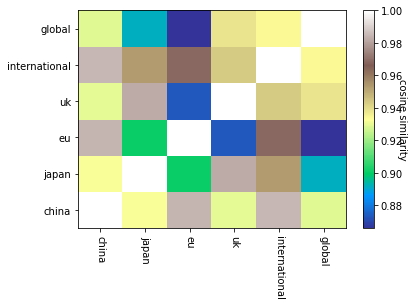

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

# from the legend on the right side, we can see that the overall relevance degree 
# is very high.
# Among them, "international" and "uk" are the most similar words 
# After these two words, I think "japan" and "china" are the also similar

In [ ]:
#  look at a heatmap of similarities between the first 20 documents in the corpus

targetDocs = newsDF['id'][:20]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = newsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, newsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

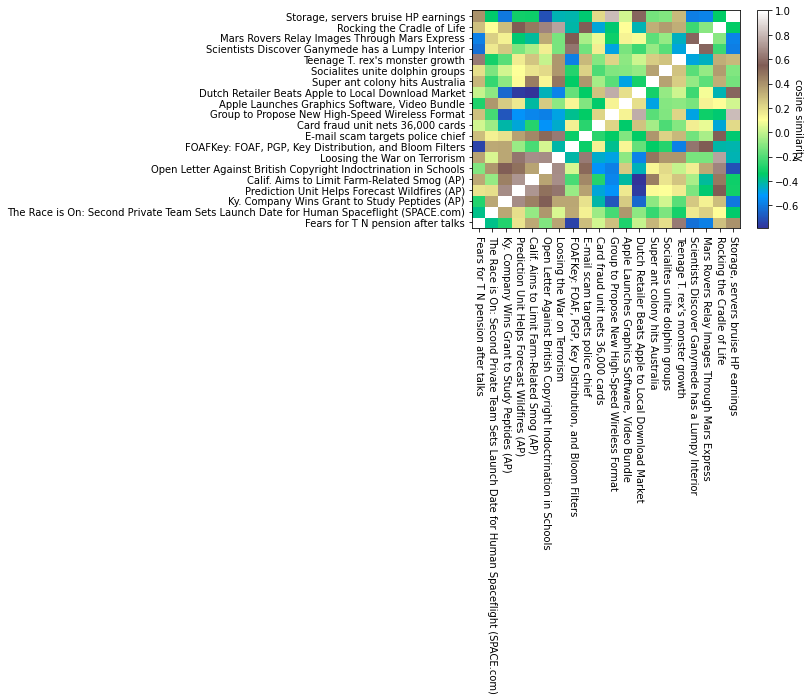

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)


In [ ]:
# The plot above is too small, please let me change the number to 5

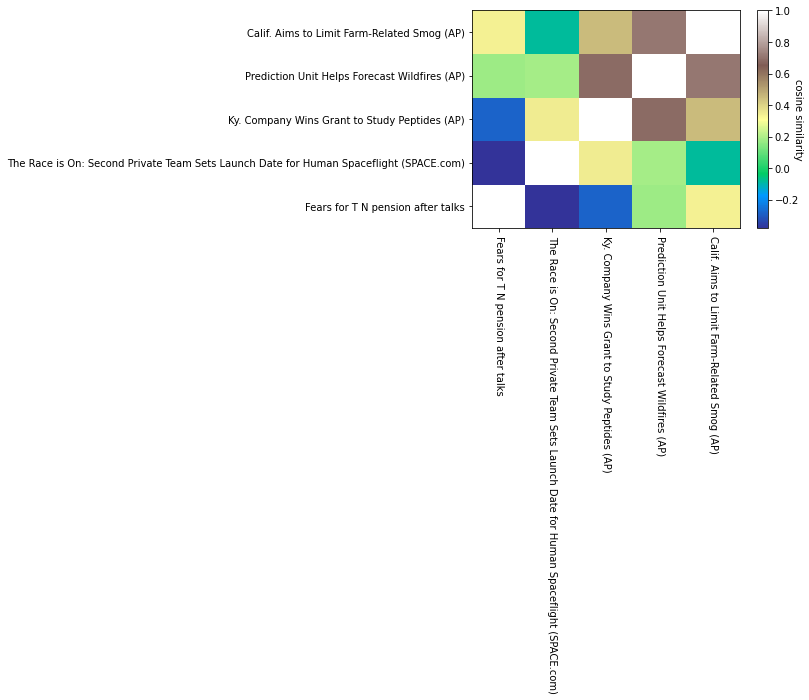

In [ ]:
#  look at a heatmap of similarities between the first 20 documents in the corpus

targetDocs = newsDF['id'][:5]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = newsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, newsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)


In [ ]:
# "Calif Aims to Limit Farm-related Smog (AP)" and 
# "Prediction Unit Helps Forecast Wildfires (AP)"
# are very similar according to their colors.

# It's in line with reality. First, farm-related Smog and wildfires are 
# strongly related to "smog"
# Second, both of them are published by AP

In [ ]:
# lheatmap of similarities between the first 5 documents and our keywords:

heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = newsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, newsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)


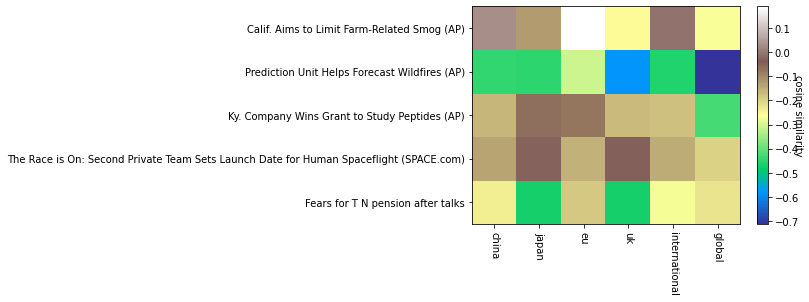

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
# "The Race is On: Second Private Team Sets Launch Date for Human Spaceflight"
# and 
# "japan"
# are most similar in this plot.
# However, I looked up for the article, it has nothing to do with japan.
# So it's wrong in this example

# Plus, 
# "The Race is On: Second Private Team Sets Launch Date for Human Spaceflight"
# is also similar to 
# "UK"
# However, this does not fit the reality

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [ ]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

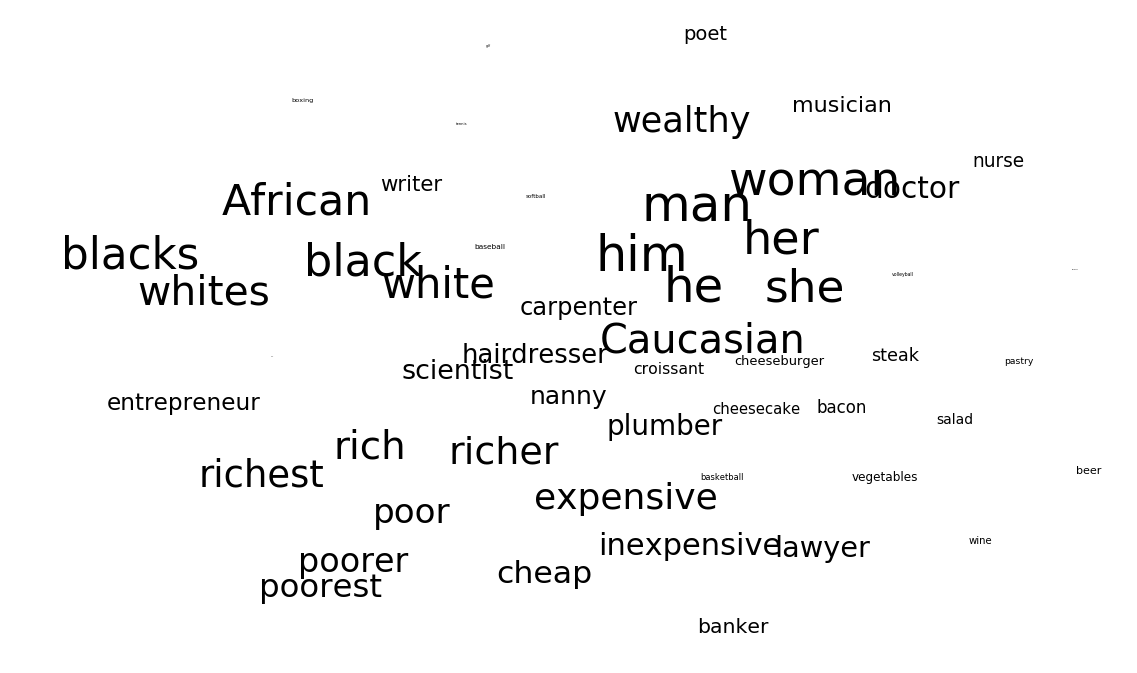

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

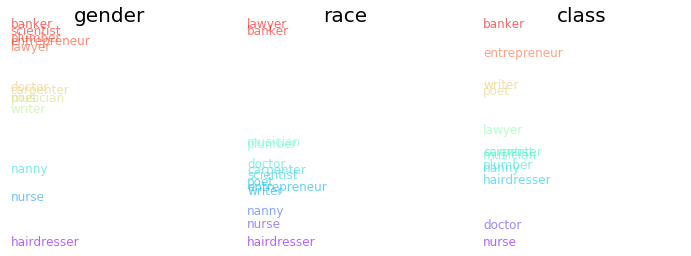

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

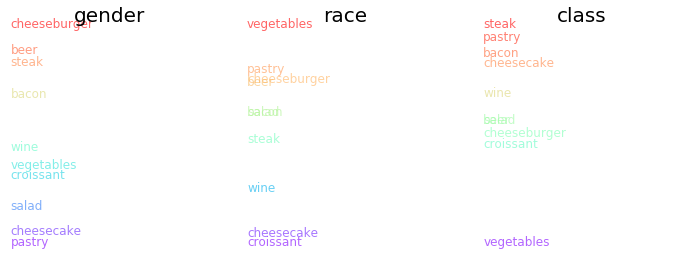

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

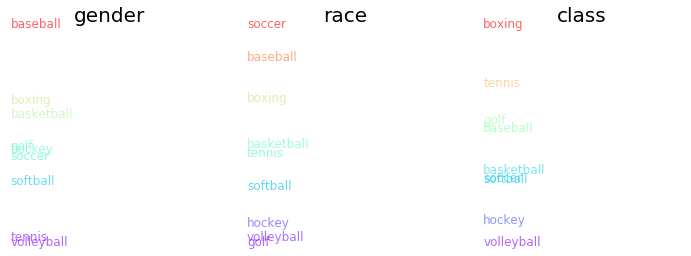

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [1]:
# It should be noted that my dataset happens to be a news database
# So the way I exert the techniques may be quite similar.
# However, I'm adjusting keywords and adding the new dimension

In [2]:
# I'm running this jupyter notebook in google's colab, so I have to install the package first
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-4oohp86l
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-4oohp86l
     |████████████████████████████████| 5.5MB 5.3MB/s 
     |████████████████████████████████| 122kB 29.9MB/s 
     |████████████████████████████████| 163kB 38.2MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 133kB 43.0MB/s 
     |████████████████████████████████| 32.8MB 117kB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 5.1MB 39.0MB/s 
     |████████████████████████████████| 7.3MB 44.1MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-cp37-none-any.whl size=34956 sha256=be8480d121db643ee3d699e0f0c0e73219f82648e5fa417bd0093ef2246f6168
  Stored in directory: /tmp/pip-ephem-wh

In [3]:
# Load data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [5]:
newsDF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AG_News_Classification_Dataset/test.csv")

In [ ]:
newsDF[:3]

# Consists of 1-4 numbers which represents class of which 1-World, 2-Sports, 3-Business, 4-Sci/Tech

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [6]:
newsDF.columns = ['category', 'title', 'text']
newsDF[:3]

,category,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [7]:
# When we normalize here, we don't use the lematized form of the word 

# Apply our functions, each row is a list of lists now
newsDF['tokenized_sents'] = newsDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
newsDF['normalized_sents'] = newsDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

newsDF[:100:10]

,category,title,text,tokenized_sents,normalized_sents
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[[Unions, representing, workers, at, Turner, N...","[[union, represent, worker, turner, newall, di..."
10,4,Group to Propose New High-Speed Wireless Format,LOS ANGELES (Reuters) - A group of technology...,"[[LOS, ANGELES, Reuters], [A, group, of, techn...","[[los, angeles, reuters], [group, technology, ..."
20,4,IBM to hire even more new workers,"By the end of the year, the computing giant pl...","[[By, the, end, of, the, year, the, computing,...","[[end, year, compute, giant, plan, big, headco..."
30,2,They've caught his eye,"In quot;helping themselves, quot; Ricky Bryan...","[[In, quot;helping, themselves, quot, Ricky, B...","[[quot;helping, quot, ricky, bryant, chas, ges..."
40,2,Johnson Helps D-Backs End Nine-Game Slide (AP),AP - Randy Johnson took a four-hitter into the...,"[[AP, Randy, Johnson, took, a, four, hitter, i...","[[ap, randy, johnson, take, hitter, 9, inning,..."
50,1,US fighter squadron to be deployed in South Ko...,AFP - A squadron of US Air Force F-15E fighter...,"[[AFP, A, squadron, of, US, Air, Force, F-15E,...","[[afp, squadron, air, force, f-15e, fighter, b..."
60,2,"Sutton Adds Haas, Cink to Ryder Cup Team",MILWAUKEE (Sports Network) - U.S. Ryder Cup c...,"[[MILWAUKEE, Sports, Network], [U.S., Ryder, C...","[[milwaukee, sport, network], [u.s, ryder, cup..."
70,4,China's Red Flag Linux to focus on enterprise,"Red Flag Software Co., the company behind Chin...","[[Red, Flag, Software, Co., the, company, behi...","[[red, flag, software, co., company, china, le..."
80,1,"Kerry Widens Lead in California, Poll Finds (R...",Reuters - Democratic challenger John Kerry\has...,"[[Reuters, Democratic, challenger, John], [Ker...","[[reuters, democratic, challenger, john], [ker..."
90,1,U.S. Brokers Cease-fire in Western Afghanistan,KABUL (Reuters) - The United States has broke...,"[[KABUL, Reuters], [The, United, States, has, ...","[[kabul, reuters], [unite, state, broker, ceas..."


In [8]:
# Now get started with Word2Vec

# To load data, give all the sentences to the trainer
newsW2V = gensim.models.word2vec.Word2Vec(newsDF['normalized_sents'].sum())


In [9]:
# visualize with dimension reduction

# words to create dimensions
newsTargetWords = ['young','old','child','kid',
                   'man', 'woman', 'black', 'white', 'rich', 
                   'expensive', 'wealthy', 'poor',
                   'cheap'
]

# words will be mapping
newsTargetWords += ["manager","officer","scientist", "officer",
                    'professor',  'engineer',
                    'designer', 'broker', 'dealer',
                    'football', 'basketball', 'hockey', 'soccer',
                    'golf', 'baseball'
                     ]
                    
wordsSubMatrix = []
for word in newsTargetWords:
    wordsSubMatrix.append(newsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix


array([[ 0.18048103,  0.12347803, -0.1930924 , ..., -0.10580441,
        -0.13900736,  0.19419906],
       [ 0.33235663,  0.21649365, -0.33069566, ..., -0.18678515,
        -0.2532094 ,  0.3484155 ],
       [ 0.26861086,  0.18167895, -0.28019762, ..., -0.14901195,
        -0.20092463,  0.27219608],
       ...,
       [ 0.17865515,  0.12253501, -0.17627998, ..., -0.10097586,
        -0.13151097,  0.18485136],
       [ 0.08796092,  0.0560208 , -0.08930258, ..., -0.05026506,
        -0.06705155,  0.0936493 ],
       [ 0.21304914,  0.14377086, -0.20523025, ..., -0.12210235,
        -0.1571965 ,  0.20378764]], dtype=float32)

In [10]:
pcaWordsnews = sklearn.decomposition.PCA(n_components = 20).fit(wordsSubMatrix)
reducedPCA_datanews = pcaWordsnews.transform(wordsSubMatrix)
# T-SNE is theoretically better
tsneWordsnews = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datanews)

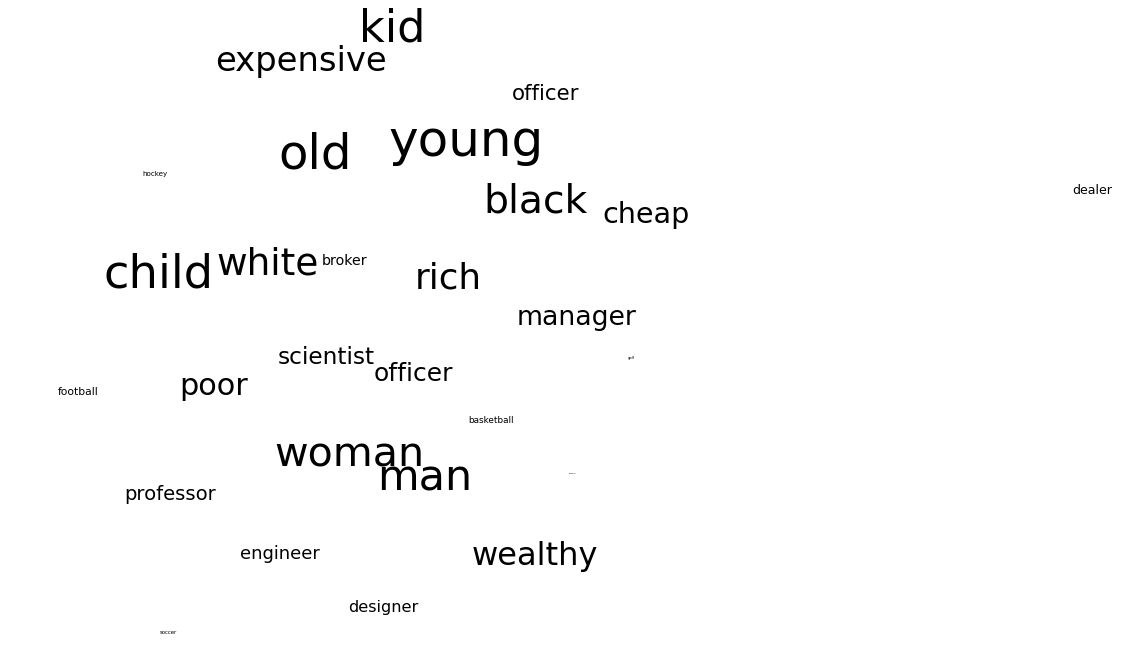

In [11]:
# Plot

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsnews[:, 0], tsneWordsnews[:, 1], alpha = 0) 
for i, word in enumerate(newsTargetWords):
    ax.annotate(word, (tsneWordsnews[:, 0][i],tsneWordsnews[:, 1][i]), 
                size =  50 * (len(newsTargetWords) - i) / len(newsTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [12]:
# Define some convenient functions for getting dimensions.

def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [ ]:
# calculate 4 dimensions: age, gender, race, and class.

Age = dimension(newsW2V, ['young', 'child', 'kid'], ['old'])
Gender = dimension(newsW2V, ['man'], ['woman'])
Race = dimension(newsW2V, ['black'], ['white'])
Class = dimension(newsW2V, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap'])

In [ ]:
# Here we have some words

Occupations = ["manager","officer","scientist", "officer",
               'professor',  'engineer',
               'designer', 'broker', 'dealer']

Sports  = ['football', 'basketball', 'hockey', 'soccer',
           'golf', 'baseball']

In [ ]:
# Define a function to project words in a word list to each of the three dimensions.
import pandas 

def makeDF(model, word_list):
    a = []
    g = []
    r = []
    c = []
    for word in word_list:
        a.append(sklearn.metrics.pairwise.cosine_similarity(newsW2V[word].reshape(1,-1), Age.reshape(1,-1))[0][0])
        g.append(sklearn.metrics.pairwise.cosine_similarity(newsW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(newsW2V[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(newsW2V[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'age':a ,'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

In [ ]:
# Get the projections.


OCCdf = makeDF(newsW2V, Occupations) 
Sportsdf = makeDF(newsW2V, Sports)

In [ ]:
# Define some useful functions for plotting.

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

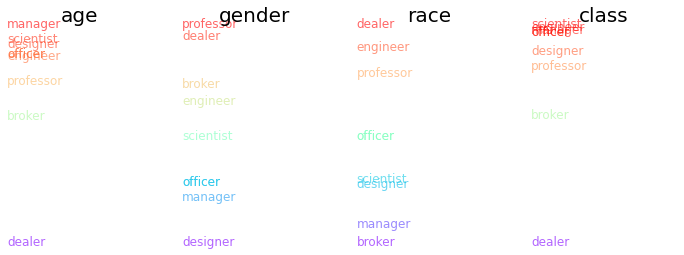

In [ ]:
# Plot the occupational words in each of the three dimensions.

# Occupations

fig = plt.figure(figsize = (12,4))
ax0 = fig.add_subplot(141)
PlotDimension(ax0, OCCdf, 'age')
ax1 = fig.add_subplot(142)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(143)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(144)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

# manager and scientist are at the top in the age column.
# This makes sense since in the real world, managers and scientist are more 
# likely to be those who are older

# But maybe designers are not so strongly related to people's gender. Also, 
# we see that many designer is a relatively gender-equal profession

# Scientist and manager are at the top of class
# True.

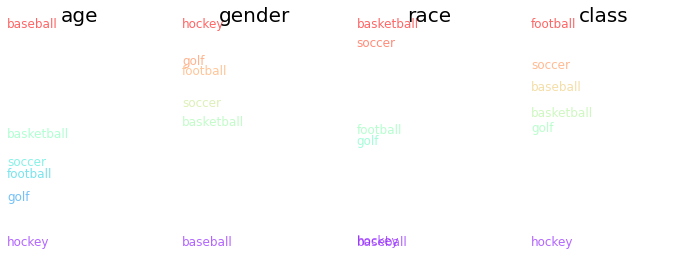

In [ ]:
# Plot the sports words in each of the three dimensions.

# Sports

fig = plt.figure(figsize = (12,4))
ax0 = fig.add_subplot(141)
PlotDimension(ax0, Sportsdf, 'age')
ax1 = fig.add_subplot(142)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(143)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(144)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

# Seems like hockey is less related to players' age

# Indeed, black people almost dominate basketball in the US

# It's interesting to see that football/soccer is more connected with "class"
# In the real world, more football athletes are considered to belong to the upper class.

In [ ]:
# In the dimension of occupations, it explains the most variation in the projection of my words
# The variations of age and class are the most significant among four of them.
# It's very intuitive because it is how the world works
# Those who are older are more likely to be managers/scientists.
# And some professions like the manager and scientist are regarded as the upper classes

In [ ]:
# Stretch: Average together multiple antonym pairs to create robust semantic 
# dimensions. How do word projections on these robust dimensions differ 
# from single-pair dimensions?

In [17]:
# calculate 4 dimensions: age, gender, race, and class.

multiple_dimentions = dimension(newsW2V, ['young', 'child', 'kid', 'old','man', 'woman'],
                                ['black','white','rich', 'expensive', 'wealthy','poor', 'cheap'])


many_words = ["manager","officer","scientist", "officer",
               'professor',  'engineer',
               'designer', 'broker', 'dealer',
              'football', 'basketball', 'hockey', 'soccer',
              'golf', 'baseball']

In [18]:
# Define a function to project words in a word list to each of the three dimensions.
import pandas 

def makeDF(model, word_list):
    m = []
    for word in word_list:
        m.append(sklearn.metrics.pairwise.cosine_similarity(newsW2V[word].reshape(1,-1), multiple_dimentions.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'multiple_dimension':m}, index = word_list)
    return df

In [19]:
# Get the projections.

multidf = makeDF(newsW2V, many_words) 

In [20]:
# Define some useful functions for plotting.

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

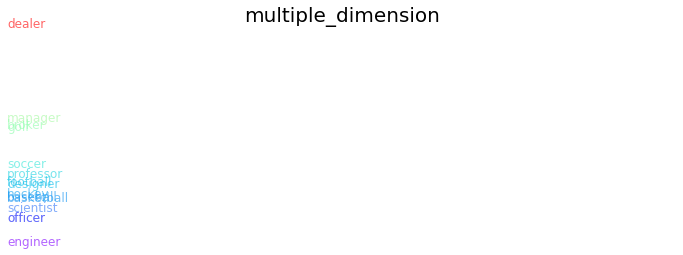

In [21]:
# Plot the occupational words in each of the three dimensions.

# multiple

fig = plt.figure(figsize = (12,4))
ax0 = fig.add_subplot(111)
PlotDimension(ax0, multidf, 'multiple_dimension')
plt.show()

In [ ]:
# The plot is very different from how it was in the single-pair dimensions
# Dealer usually appears at the bottom in single-pair dimension plots,
# however, this time it is on the top of the graph

# In this multiple dimention plot, I find it hard to interpret the plot as
# there is no distinct definition for this dimension

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [ ]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [ ]:
# I download a Data Analyst Jobs dataset from from: https://www.kaggle.com/andrewmvd/data-analyst-jobs
# It includes 2253 job listings scraped from glassdoor
# It focus on job descriotions about data analysts

In [ ]:
jobDF = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/DataAnalyst_job_description.csv', 
                        index_col = False)
jobDF.head()
jobDF = jobDF.drop(columns=['Unnamed: 0'])
jobDF.head()


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [ ]:
# the dataset is too large, so I'm going to reduce the size
print(len(jobDF))

jobDF = jobDF[:500]

2253


In [ ]:
jobDF['tokenized_sents'] = jobDF['Job Description'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
jobDF['normalized_sents'] = jobDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
jobDF.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,tokenized_sents,normalized_sents
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,"[[Are, you, eager, to, roll, up, your, sleeves...","[[eager, roll, sleeve, harness, datum, drive, ..."
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,"[[Overview, Provides, analytical, and, technic...","[[overview, provide, analytic, technical, supp..."
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,"[[We, ’re, looking, for, a, Senior, Data, Anal...","[[look, senior, datum, analyst, love, mentorsh..."
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,"[[Requisition, NumberRR-0001939], [Remote], [Y...","[[requisition, numberrr-0001939], [remote], [y..."
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True,"[[ABOUT, FANDUEL, GROUP], [FanDuel, Group, is,...","[[fanduel, group], [fanduel, group, world, cla..."


In [ ]:
jobW2V = gensim.models.word2vec.Word2Vec(jobDF['normalized_sents'].sum(), hs=1, negative=0)


In [ ]:
# define a function to calculate the likelihood of each job description

def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [ ]:
# apply this function to every job description

jobDF['likelihood'] = jobDF['normalized_sents'].apply(lambda x: adprob(x, jobW2V))
jobDF.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,tokenized_sents,normalized_sents,likelihood
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,"[[Are, you, eager, to, roll, up, your, sleeves...","[[eager, roll, sleeve, harness, datum, drive, ...",-62.278793
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,"[[Overview, Provides, analytical, and, technic...","[[overview, provide, analytic, technical, supp...",-47.918854
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,"[[We, ’re, looking, for, a, Senior, Data, Anal...","[[look, senior, datum, analyst, love, mentorsh...",-60.304279
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,"[[Requisition, NumberRR-0001939], [Remote], [Y...","[[requisition, numberrr-0001939], [remote], [y...",-46.903629
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True,"[[ABOUT, FANDUEL, GROUP], [FanDuel, Group, is,...","[[fanduel, group], [fanduel, group, world, cla...",-44.722145


In [ ]:
# take a look at the top 10 job descriptions that have the highest likelihood.

for ad in jobDF.sort_values(by = 'likelihood', ascending = False)['Job Description'][:10]:
    print (ad + '\n\n')

color:black;mso-ansi-language:EN-US;mso-fareast-language:EN-IN;mso-bidi-language:

AR-SA' lang='EN-US'>Should have an insurance background

color:black;mso-ansi-language:EN-US;mso-fareast-language:EN-IN;mso-bidi-language:

AR-SA' lang='EN-US'>Experience of working with Adobe

XD, MicroStrategy, Acomona/Acumana


Hi,

Â

Hope you are doing well!!

Â

Enclosed is the job description for your perusal. If you are interested please send me your updated resume and your expected rate for this position ASAP.

Â

Job Title:ÂBusiness Analyst / Data Analyst

Location:ÂWeehawken, NJ

Duration: 12+ÂMonths

Position type: C2C & W2

Start Date:ÂImmediate

Â

Job Description:

Â

Good data analysis/SQL, good requirements gathering and documenting, good communication skills, good soft skills like managing conflicting situations and negotiating, able to deliver on time

Â

Best Regards

Â

Shaik Hefaz

Technical RecruiterÂ

Softcom Systems, Inc.

Email:

Hangouts:

Skype: hefazsk

475, Wall Street,ÂPrin

In [ ]:
#  take a look at the bottom 10 job descriptions that have the lowest likelihood

In [ ]:
for ad in jobDF.sort_values(by = 'likelihood')['Job Description'][:10]:
    print (ad + '\n\n')

Data Analyst (Little Ferry, NJ) -

Develop automated business review reports from the ground up, providing the cross-functional teams with the necessary tools to make timely business decisions, including key metrics and important; retail analytics; Work to develop omni-channel marketing campaigns targeted to purposefully steer customer behavior; Interpret, analysis of collected data using different tools, statistical techniques such as MS Excel and data management systems to provide accurate & reliable reports to the company; access data from internal databases and build and maintain data systems; develop a healthy data collection systems & sound strategies for getting quality data from different sources to use it to right place efficiently; prepare presentations, conducting research and maintaining quality of database systems; assist database administrators in database administration, design, security also timely maintenance of data base as well; prepare various statistical reports on

In [ ]:
# take a look at the middle of job descriptions

for ad in jobDF.sort_values(by = 'likelihood')['Job Description'][240:250]:
    print (ad + '\n\n')

Working with William Hill, you will be at the heart of the technological revolution with one of the world's most trusted betting and gaming companies. William Hill deals with projects ranging from desktop or mobile casinos and betting sites, to name a few. We process 500 online Sportsbook bets per second each Saturday, that's the same as the number of orders processed by Amazon UK, on its busiest day of the year. We deal with more than 20 million users daily; impressed? You can be sure there are many more challenges waiting for you.

When we say cutting edge, we mean it. Here, you can work on highly reliable systems with low latency, much like the transactional systems of the best financial institutions, butwith the fun included.

You will have access to development opportunities, including IT conferences, internal training, and lunch and learn sessions. You will be part of a great working atmosphere, performing complex work in a collaborative team of amazing people, with forward-think

In [ ]:
# do the same for phrases corresponding to job skills

adprob([["python", "programming"]], jobW2V)


-6.3469734

In [ ]:
adprob([["cloud", "computing"]], jobW2V)


-7.757412

In [ ]:
adprob([["c++", "programming"]], jobW2V) # seems like no relevant info


0.0

In [ ]:
adprob([["c", "programming"]], jobW2V)

# C language is the most likely to be appeared among these programming languages


-9.1678505

In [ ]:
adprob([["java", "programming"]], jobW2V)


-8.462631

In [ ]:
adprob([["front", "engineer"]], jobW2V)


-6.3469734

In [ ]:
adprob([["back", "engineer"]], jobW2V)

# back engineers are more likely to 

-17.556417

In [ ]:
adprob([["data", "engineer"]], jobW2V)

# back engineers are more likely to 

-6.3469734

In [ ]:
adprob([["data", "scientist"]], jobW2V)

# scientist are more likely than engineers

-8.462631

In [ ]:
jobDF.groupby("Size")[['likelihood']].mean().sort_values('likelihood', ascending = False)


# Apparently, small business are less likely, even though 201 to 500 business is 
# an exception
# So maybe the situation is like a U-shaped shape


,likelihood
Size,
-1,-44.648099
1 to 50 employees,-49.378412
Unknown,-49.811043
501 to 1000 employees,-49.924094
51 to 200 employees,-54.449899
10000+ employees,-56.034225
5001 to 10000 employees,-56.083636
1001 to 5000 employees,-57.267202
201 to 500 employees,-58.766717


In [ ]:
jobDF.groupby("Revenue")[['likelihood']].mean().sort_values('likelihood', ascending = False)


# This is different from the results obtained from just above
# There is no clear formula in this case

,likelihood
Revenue,
-1,-44.648099
$50 to $100 million (USD),-49.454793
$2 to $5 billion (USD),-49.539708
Less than $1 million (USD),-50.120583
$1 to $5 million (USD),-50.810944
Unknown / Non-Applicable,-51.592092
$500 million to $1 billion (USD),-54.025237
$5 to $10 billion (USD),-54.494635
$100 to $500 million (USD),-55.896505


In [ ]:
jobDF.groupby("Sector")[['likelihood']].mean().sort_values('likelihood', ascending = False)

# Real estate, food and retail are sectors that are less likely
# Finance, Insurance and Consumer Services are more likely

# It looks like fundamental industries are less likely 
# while more advanded industries are more likely 

,likelihood
Sector,
Real Estate,-43.372810
"Restaurants, Bars & Food Services",-43.952751
Retail,-44.098713
"Construction, Repair & Maintenance",-45.644811
Education,-47.290016
Non-Profit,-47.387944
-1,-49.342335
Biotech & Pharmaceuticals,-50.865908
Accounting & Legal,-51.464109


In [ ]:
print(jobDF.columns)

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply', 'tokenized_sents', 'normalized_sents', 'likelihood'],
      dtype='object')


In [ ]:
jobDF.groupby("Industry")[['likelihood']].mean().sort_values('likelihood', ascending = False)

# Still, the pattern remains 
# It looks like basic industries are less likely 
# while more advanded industries are more likely 

,likelihood
Industry,
Other Retail Stores,-33.224148
General Repair & Maintenance,-37.563126
Food & Beverage Stores,-39.222523
Preschool & Child Care,-39.578175
Food & Beverage Manufacturing,-40.036285
Municipal Governments,-41.234001
Real Estate,-43.372810
Casual Restaurants,-43.952751
Sports & Recreation,-44.722145


In [ ]:
# Now, please let me do it again with the help from the resume model provided 



In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('/content/drive/My Drive/Colab Notebooks/resumeAll.model')

In [ ]:
# define a function to calculate the likelihood of each job description

def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [ ]:
# apply this function to every job description

jobDF['likelihood'] = jobDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))
jobDF.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,tokenized_sents,normalized_sents,likelihood
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,"[[Are, you, eager, to, roll, up, your, sleeves...","[[eager, roll, sleeve, harness, datum, drive, ...",-89.745735
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,"[[Overview, Provides, analytical, and, technic...","[[overview, provide, analytic, technical, supp...",-69.596817
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,"[[We, ’re, looking, for, a, Senior, Data, Anal...","[[look, senior, datum, analyst, love, mentorsh...",-92.845764
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,"[[Requisition, NumberRR-0001939], [Remote], [Y...","[[requisition, numberrr-0001939], [remote], [y...",-69.971413
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True,"[[ABOUT, FANDUEL, GROUP], [FanDuel, Group, is,...","[[fanduel, group], [fanduel, group, world, cla...",-63.830631


In [ ]:
# take a look at the top 10 job descriptions that have the highest likelihood.
# these 10 job ads are most likely to find an appropriate pool of workers in the resume bank 

for ad in jobDF.sort_values(by = 'likelihood', ascending = False)['Job Description'][:3]:
    print (ad + '\n\n')

Hi,

Â

Hope you are doing well!!

Â

Enclosed is the job description for your perusal. If you are interested please send me your updated resume and your expected rate for this position ASAP.

Â

Job Title:ÂBusiness Analyst / Data Analyst

Location:ÂWeehawken, NJ

Duration: 12+ÂMonths

Position type: C2C & W2

Start Date:ÂImmediate

Â

Job Description:

Â

Good data analysis/SQL, good requirements gathering and documenting, good communication skills, good soft skills like managing conflicting situations and negotiating, able to deliver on time

Â

Best Regards

Â

Shaik Hefaz

Technical RecruiterÂ

Softcom Systems, Inc.

Email:

Hangouts:

Skype: hefazsk

475, Wall Street,ÂPrinceton, NJ-08540,ÂFax: 609-751-9077

Â

Under Bill s.1618 Title III passed by the 105th U.S. Congress thisÂmail cannot be considered as "spam" as long as we include contactÂinformation and a remove link for removal from our mailing list. InÂorder to not be in the recipients-list for this mail, please revert toÂus 

In [ ]:
#  take a look at the bottom 10 job descriptions that have the lowest likelihood
# job ads are most least to find an appropriate pool of workers in the resume bank 

In [ ]:
for ad in jobDF.sort_values(by = 'likelihood')['Job Description'][:3]:
    print (ad + '\n\n')

Sr Business Data Analyst 12+months Jersey City, NJ Remote Initially cause of covid later on Onsite Job description bull Financial Data Modeling Data Mining Knowledge bull Reverse engineering functional specifications from data bull Independently query data from multiple relational databases for analysis bull Work closely with IT and Operations partners bull Work with client Security Coding and leverage external vendors and standards organizations bull Work Independently to complete a task Required Skills bull Working experience of 8 years min as Business Analyst bull Strong background in financial reference data and capital markets, fund services and custody on financial products bull Data analysis and mapping (able to query data, analyze and map) bull College degree, specialized training or equivalent work experience bull Data Oriented with an excellent attention to detail bull Experienceunderstanding of business process reengineering and business modeling concepts, business systems d

In [ ]:
# take a look at the middle of job descriptions

for ad in jobDF.sort_values(by = 'likelihood')['Job Description'][240:242]:
    print (ad + '\n\n')

Title Data AnalystData Scanning with Financial Industry exp Location NYC, NY Duration 6+ Months Education Qualification Bachelor's Degree in Computer Science, Information Technology (IT), or closely related field. Masterrsquos in Computer Science or related degree Job Description Data Scanning Team - Responsible for determining systems requirements for new or modified database application programs, creates the system specifications and Is responsible for the development, testing and implementation of efficient, cost effective application solutions. Will receive general direction from the Manager, work closely with business analysts to identify and specify complex business requirements and processes. May co-ordinate the activities of the section with the client area and other IT sections (e.g., data base, operations, technical support). Work in conjunction with the data architectmodeler on the data warehouse reporting solution. Possess expertise in writing and tuning, view, stored proce

In [ ]:
# do the same for phrases corresponding to job skills

adprob([["python", "programming"]], resume_model)



-14.355247

In [ ]:
adprob([["cloud", "computing"]], resume_model)


-9.004791

In [ ]:
adprob([["c++", "programming"]], resume_model)


-8.462631

In [ ]:
adprob([["c", "programming"]], resume_model)

# the result is changing! 
# now c becomes the most likely to appear!

# job ads about c programming are most likely to find an appropriate pool of workers in the resume bank 
# among these languages

-20.827463

In [ ]:
adprob([["java", "programming"]], resume_model)


-7.7715044

In [ ]:
adprob([["front", "engineer"]], resume_model)

# front engineers are more likely to appear

-27.60473

In [ ]:
adprob([["back", "engineer"]], resume_model)

-22.095171

In [ ]:
adprob([["data", "engineer"]], resume_model)


-21.530478

In [ ]:
adprob([["data", "scientist"]], resume_model)

# scientists are more likely than engineers to find a proper pool 

-22.50639

In [ ]:
# look at the mean likelihood score of each hiring organization

In [ ]:
jobDF.groupby("Company Name")[['likelihood']].mean().sort_values('likelihood', ascending = False)

# I'm not familiar with these names
# But Fidelis Group is really likely to do well on hiring

,likelihood
Company Name,
Softcom Systems\n4.4,-24.623791
Siri InfoSolutions\n3.4,-26.611385
Clear Technology Consulting,-28.321169
Blue Rock Consulting\n5.0,-32.569050
SMBC\n3.0,-32.569542
...,...
"Orbis, Inc.\n4.9",-157.730104
Royal Communications\n3.0,-164.528931
SIAL TECHNOLOGY PARTNERS,-164.972610


In [ ]:
# look at the mean likelihood of each location.

jobDF.groupby("Location")[['likelihood']].mean().sort_values('likelihood', ascending = False)

# I'm not familiar with these locations, but 
# Staten Island, NY will not do well in their hiring 

,likelihood
Location,
"Staten Island, NY",-37.535522
"Valley Stream, NY",-40.520542
"American Fork, UT",-45.742840
"Haworth, NJ",-46.325665
"Weehawken, NJ",-46.422375
"Parsippany, NJ",-46.965630
"Chesapeake, VA",-50.067539
"Visalia, CA",-54.161343
"Hanford, CA",-56.044006


In [ ]:
jobDF.groupby("Industry")[['likelihood']].mean().sort_values('likelihood', ascending = False)

# It looks like basic industries are less likely to do well 
# They may include, for example, general repair, retail, municipal government
# while more advanded industries are more likely 
# for example: Consulting, Advertising & Marketing, Internet and Legal 
# are very likely to find appropirate workers

,likelihood
Industry,
General Repair & Maintenance,-50.674770
Other Retail Stores,-51.556160
Preschool & Child Care,-54.161343
Municipal Governments,-56.619354
Food & Beverage Manufacturing,-59.266800
Food & Beverage Stores,-60.734032
Real Estate,-62.386938
Sports & Recreation,-63.830631
Utilities,-68.480949


# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [ ]:
import copy

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [ ]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, establish, main, drug, ..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, woman, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, establish, activity, high, response, ra..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[begin, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
5,1995,Breast Cancer,Validation of a model that identifies high ris...,GM Clark,Breast cancer patients with 10 or more positiv...,69,"[[Breast, cancer, patients, with, 10, or, more...","[[breast, cancer, patient, positive, lymph, no..."
6,1995,Genitourinary Cancer,Validation of the PROSQOLI: a pragmatic outcom...,M Stockler,Rationale: Traditional outcome measures are un...,649,"[[Rationale], [Traditional, outcome, measures,...","[[rationale], [traditional, outcome, measure, ..."
7,1995,Preclinical Experimental Therapeutics - Other,'In vitro' comparative assay on fluorouracil (...,A Abad,The clinical experience with biochemical modul...,1609,"[[The, clinical, experience, with, biochemical...","[[clinical, experience, biochemical, modulatio..."
8,1995,Tumor Biology,'Medical cultural diversity' among medical onc...,R Hochman,Most MO rely on prospective randomized trials....,1633,"[[Most, MO, rely, on, prospective, randomized,...","[[mo, rely, prospective, randomize, trial], [o..."
9,1995,Developmental TherapeuticsÑClinical Pharmacolo...,13-cis-retinoic acid plus low dose recombinant...,GM Turola,Both interferons and retinoids are known to po...,709,"[[Both, interferons, and, retinoids, are, know...","[[interferon, retinoid, know, possess, antipro..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [ ]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


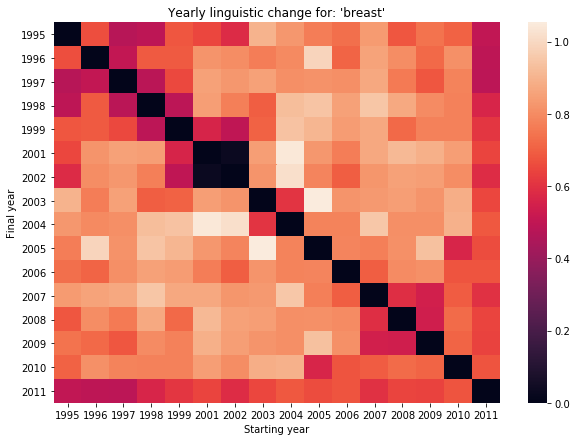

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


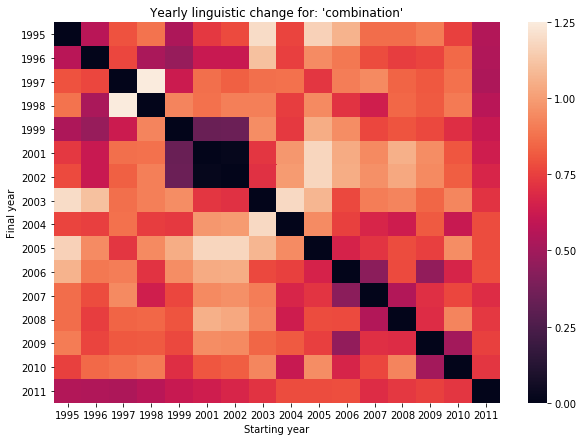

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [ ]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [ ]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


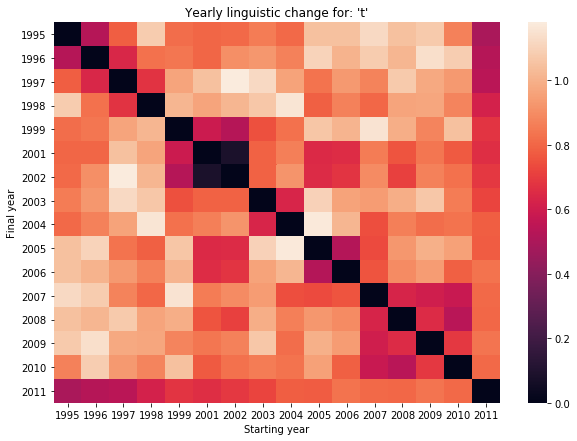

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


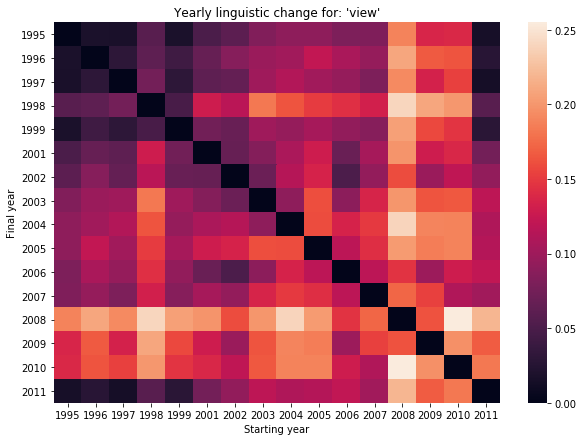

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud_2020.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 